Cell 1:
Import Libraries

In [2]:
#import libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, 
                             roc_auc_score, classification_report, confusion_matrix)
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import joblib
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import SklearnClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import shap

ModuleNotFoundError: No module named 'numpy'

Cell 2:
Load the dataset

In [ ]:
# Load the dataset:
df = pd.read_csv(r'data.csv') # change to dataset location

# Fill the missing values:
df.fillna(method="ffill", inplace=True)

C:\Users\MSI\AppData\Local\Temp\ipykernel_16488\533099284.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)


Cell 3:
Extract the correct information from the category colum (hypen-seperated values from the first colum)

In [ ]:
# Functions to extract unique files and records for each category:
def find_category(file_name):
    if "-" in file_name:
        return file_name.split("-")[0]
    else:
        return file_name

def find_category_name(file_name):
    if "-" in file_name:
        parts = file_name.split("-")
        return parts[1] if len(parts) > 1 else file_name
    else:
        return file_name

def extract_unique_file_id(file_name):
    return file_name.rsplit('-', 1)[0]

Cell 4:
Create new columns based on above information ( category, category_name, unique_file_id)
Summarise the dataset malware distribution

In [ ]:
# Create new columns:
df["category"] = df["Category"].apply(find_category)
df["category_name"] = df["Category"].apply(find_category_name)
df["unique_file_id"] = df["Category"].apply(extract_unique_file_id)


# Compute unique file counts per malware family and create a summary DataFrame:
unique_counts = df.groupby('category_name')['unique_file_id'].nunique()
total_records = df['category_name'].value_counts()
df_category_summary = pd.DataFrame({
    'Total_Records': total_records,
    'Unique_File_Counts': unique_counts
})
df_category_summary['Percentage'] = (df_category_summary['Total_Records'] / len(df)) * 100
df_category_summary = df_category_summary.reset_index().rename(columns={'index': 'category_name'})
print("Category Summary:")
print(df_category_summary)
df_category_summary.to_csv("df_category_summary.csv", index=False)

Category Summary:
   category_name  Total_Records  Unique_File_Counts  Percentage
0   180solutions           2000                 200    3.413202
1            Ako           2000                 200    3.413202
2         Benign          29298                   1   50.000000
3            CWS           2000                 200    3.413202
4          Conti           1988                 200    3.392723
5         Emotet           1967                 200    3.356884
6          Gator           2200                 216    3.754522
7           Maze           1958                 176    3.341525
8           Pysa           1717                 192    2.930234
9        Reconyc           1570                 157    2.679364
10       Refroso           2000                 200    3.413202
11          Scar           2000                 200    3.413202
12         Shade           2128                 229    3.631647
13          TIBS           1410                 141    2.406308
14   Transponder      

Cell 5:
Preprocesses data (encoding labels, splitting into train/validation/test sets).
Trains multiple classifiers using GroupKFold for cross-validation, evaluates them, computes SHAP values, and saves results.

Feature columns defined: ['pslist.nproc', 'pslist.nppid', 'pslist.avg_threads', 'pslist.nprocs64bit', 'pslist.avg_handlers', 'dlllist.ndlls', 'dlllist.avg_dlls_per_proc', 'handles.nhandles', 'handles.avg_handles_per_proc', 'handles.nport', 'handles.nfile', 'handles.nevent', 'handles.ndesktop', 'handles.nkey', 'handles.nthread', 'handles.ndirectory', 'handles.nsemaphore', 'handles.ntimer', 'handles.nsection', 'handles.nmutant', 'ldrmodules.not_in_load', 'ldrmodules.not_in_init', 'ldrmodules.not_in_mem', 'ldrmodules.not_in_load_avg', 'ldrmodules.not_in_init_avg', 'ldrmodules.not_in_mem_avg', 'malfind.ninjections', 'malfind.commitCharge', 'malfind.protection', 'malfind.uniqueInjections', 'psxview.not_in_pslist', 'psxview.not_in_eprocess_pool', 'psxview.not_in_ethread_pool', 'psxview.not_in_pspcid_list', 'psxview.not_in_csrss_handles', 'psxview.not_in_session', 'psxview.not_in_deskthrd', 'psxview.not_in_pslist_false_avg', 'psxview.not_in_eprocess_pool_false_avg', 'psxview.not_in_ethread_po

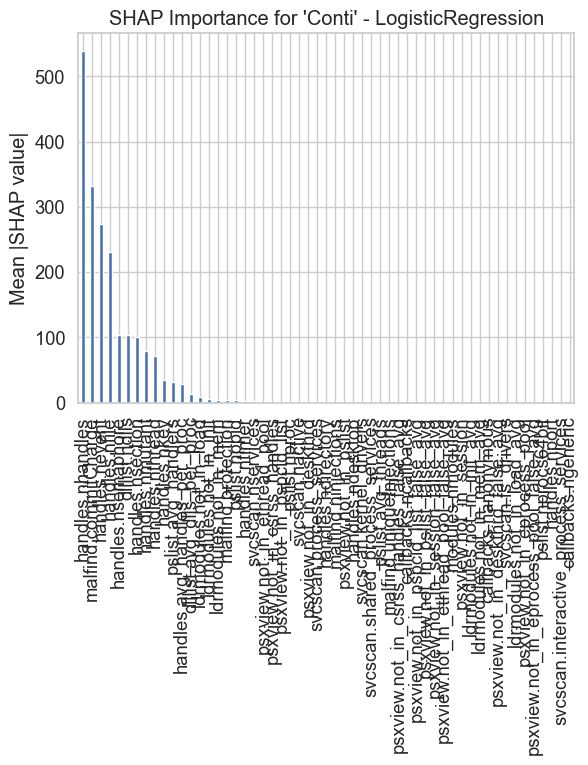


Validation Set Classification Report for LogisticRegression:
              precision    recall  f1-score   support

180solutions     0.1250    0.0222    0.0377        90
         Ako     0.0000    0.0000    0.0000        60
      Benign     0.9980    1.0000    0.9990      1475
         CWS     0.0000    0.0000    0.0000        50
       Conti     0.1778    0.0741    0.1046       108
      Emotet     0.0914    0.2125    0.1278        80
       Gator     0.4505    0.3534    0.3961       116
        Maze     0.1223    0.1889    0.1485        90
        Pysa     0.5714    0.0825    0.1441        97
     Reconyc     0.4286    0.0429    0.0779        70
     Refroso     0.4043    0.4750    0.4368       160
        Scar     0.1364    0.1200    0.1277       100
       Shade     0.1985    0.3714    0.2587        70
        TIBS     0.2375    0.3167    0.2714        60
 Transponder     0.0986    0.1909    0.1300       110
        Zeus     0.1349    0.1278    0.1313       133

    accuracy      

C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:


SHAP Feature Importance for 'Conti' - DecisionTree:
dlllist.avg_dlls_per_proc                 0.017011
svcscan.nservices                         0.016160
malfind.uniqueInjections                  0.004490
ldrmodules.not_in_init_avg                0.003363
malfind.commitCharge                      0.000115
ldrmodules.not_in_mem_avg                 0.000100
psxview.not_in_deskthrd_false_avg         0.000084
callbacks.ncallbacks                      0.000050
psxview.not_in_pslist_false_avg           0.000000
psxview.not_in_deskthrd                   0.000000
psxview.not_in_pspcid_list                0.000000
psxview.not_in_session                    0.000000
psxview.not_in_csrss_handles              0.000000
psxview.not_in_ethread_pool_false_avg     0.000000
psxview.not_in_ethread_pool               0.000000
psxview.not_in_eprocess_pool              0.000000
psxview.not_in_eprocess_pool_false_avg    0.000000
psxview.not_in_session_false_avg          0.000000
psxview.not_in_pspcid_list_fa

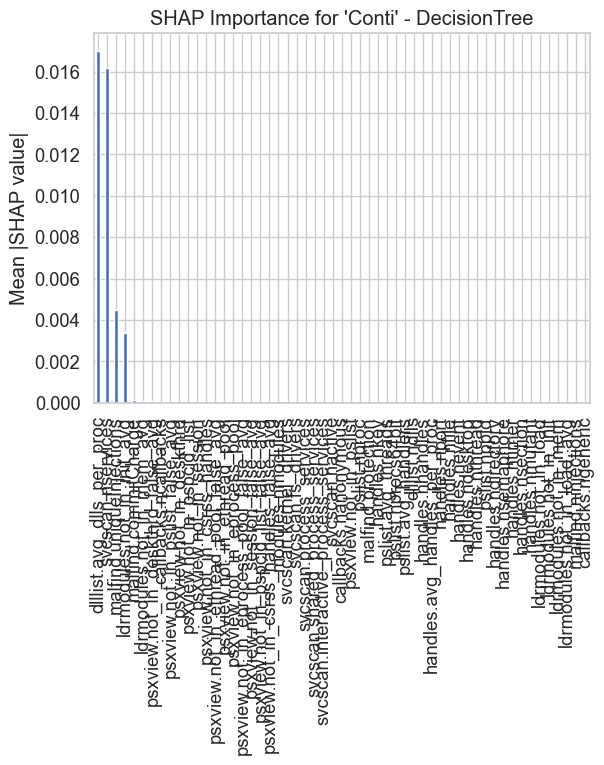


Validation Set Classification Report for DecisionTree:
              precision    recall  f1-score   support

180solutions     0.0000    0.0000    0.0000        90
         Ako     0.0000    0.0000    0.0000        60
      Benign     1.0000    0.9953    0.9976      1475
         CWS     0.0000    0.0000    0.0000        50
       Conti     0.0000    0.0000    0.0000       108
      Emotet     0.0724    1.0000    0.1350        80
       Gator     0.5057    0.3793    0.4335       116
        Maze     0.0000    0.0000    0.0000        90
        Pysa     0.4545    0.0515    0.0926        97
     Reconyc     0.0000    0.0000    0.0000        70
     Refroso     0.9800    0.3063    0.4667       160
        Scar     0.0000    0.0000    0.0000       100
       Shade     0.0000    0.0000    0.0000        70
        TIBS     0.3571    0.1667    0.2273        60
 Transponder     0.2281    0.2364    0.2321       110
        Zeus     0.0000    0.0000    0.0000       133

    accuracy            

C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:

              precision    recall  f1-score   support

180solutions     0.0000    0.0000    0.0000       550
         Ako     0.0000    0.0000    0.0000       540
      Benign     0.9997    0.9959    0.9978      8792
         CWS     0.8000    0.0179    0.0350       670
       Conti     0.0000    0.0000    0.0000       639
      Emotet     0.0661    0.9344    0.1234       488
       Gator     0.5337    0.4623    0.4954       822
        Maze     0.0000    0.0000    0.0000       580
        Pysa     0.6230    0.0705    0.1267       539
     Reconyc     0.0000    0.0000    0.0000       570
     Refroso     0.6495    0.3635    0.4661       520
        Scar     0.0000    0.0000    0.0000       600
       Shade     0.0000    0.0000    0.0000       616
        TIBS     0.7586    0.2619    0.3894       420
 Transponder     0.1713    0.1930    0.1815       570
        Zeus     0.0000    0.0000    0.0000       612

    accuracy                         0.5734     17528
   macro avg     0.2876   

In [ ]:

# ---------------------------------------------------------PREPROCESSING & ENCODING--------------------------------------------------------
meta_cols = ['Category', 'category_name', 'unique_file_id']
df_meta = df[meta_cols].copy()

le_class = LabelEncoder()
le_category = LabelEncoder()
le_catname = LabelEncoder()

df['Class_encoded'] = le_class.fit_transform(df['Class'])
df['category_encoded'] = le_category.fit_transform(df['category'])
df['category_name_encoded'] = le_catname.fit_transform(df['category_name'])

df['group_id'] = df.apply(lambda row: row['unique_file_id'] 
                                    if row['Class'] != 'Benign' 
                                    else f"benign_{row.name}", axis=1)

# Drop columns used for meta or non-numeric:
features = df.drop(columns=[
    'Category', 'Class', 'category', 'category_name',
    'Class_encoded', 'category_encoded', 'category_name_encoded',
    'unique_file_id', 'group_id'
])
target = df['category_name_encoded']


# ----------------------------------------------------------SPLITTING DATA--------------------------------------------------------------
gss = GroupShuffleSplit(n_splits=1, test_size=0.35, random_state=42)
train_idx, temp_idx = next(gss.split(df, groups=df['group_id']))
train_df = df.iloc[train_idx]
temp_df = df.iloc[temp_idx]

gss_temp = GroupShuffleSplit(n_splits=1, test_size=0.857, random_state=42)
val_idx, test_idx = next(gss_temp.split(temp_df, groups=temp_df['group_id']))
validation_df = temp_df.iloc[val_idx]
test_df = temp_df.iloc[test_idx]

def get_features_and_target(sub_df):
    X = sub_df.drop(columns=[
        'Category', 'Class', 'category', 'category_name', 
        'Class_encoded', 'category_encoded', 'category_name_encoded',
        'unique_file_id', 'group_id'
    ])
    y = sub_df['category_name_encoded']
    return X, y

X_train, y_train = get_features_and_target(train_df)
X_val, y_val = get_features_and_target(validation_df)
X_test, y_test = get_features_and_target(test_df)
feature_cols = X_train.columns.tolist()  # Add this line to define feature_cols
print("Feature columns defined:", feature_cols)  # Optional: verify the columns

meta_val = validation_df[meta_cols].copy()
meta_test = test_df[meta_cols].copy()

total = len(X_train) + len(X_val) + len(X_test)
print("Total records:", total)
print("Train:", len(X_train), f"({round((len(X_train)/total)*100,2)}%)")
print("Test:", len(X_test), f"({round((len(X_test)/total)*100,2)}%)")
print("Validation:", len(X_val), f"({round((len(X_val)/total)*100,2)}%)")


# -------------------------------------------------------CLASSIFIERS & CONFIGURATION--------------------------------------------------
rf_classifier = RandomForestClassifier(
    n_estimators=50, max_depth=5, min_samples_split=4, 
    min_samples_leaf=2, random_state=42
)
knn_classifier = KNeighborsClassifier(n_neighbors=7, weights='distance')
logistic_classifier = LogisticRegression(
    penalty='l2', C=0.5, solver='liblinear', max_iter=1000, random_state=42
)
tree_classifier = DecisionTreeClassifier(
    max_depth=5, min_samples_split=4, min_samples_leaf=2, random_state=42
)
svm_classifier = SVC(
    kernel='rbf', C=0.5, gamma='scale', probability=True, random_state=42
)

# Classifier dictionary (model, scale_required):
classifiers = {
    #'RandomForest': (rf_classifier, False),
   # 'KNN': (knn_classifier, True),
    'LogisticRegression': (logistic_classifier, True),
    'DecisionTree': (tree_classifier, False),
    #'SVM': (svm_classifier, True)
}

# Hyperparameter grids:
param_grids = {
    'RandomForest': {
        'n_estimators': [50, 75],
        'max_depth': [3, 5, 7],
        'min_samples_split': [4, 6],
        'min_samples_leaf': [2, 3]
    },
    'KNN': {
        'n_neighbors': [7, 9, 11]
    },
    'LogisticRegression': {
        'C': [0.1, 0.5, 1]
    },
    'DecisionTree': {
        'max_depth': [3, 5],
        'min_samples_split': [6, 8],
        'min_samples_leaf': [2, 3]
    },
    'SVM': {
        'C': [0.1, 0.5, 1],
        'kernel': ['rbf']
    }
}

results_dict = {}
shap_values_dict = {}
train_groups = train_df['group_id']

# Encoded value for "Conti":
conti_label = "Conti"
conti_encoded = le_catname.transform([conti_label])[0]

# Lists to collect evaluation metrics and SHAP features:
metrics_list = []
shap_features_list = []

# -------------------------------------------------------TRAINING, EVALUATION & SHAP--------------------------------------------------
for clf_name, (clf_obj, scale_required) in classifiers.items():
    print(f"\nTraining and evaluating {clf_name}...")

    # Build pipeline:
    if scale_required:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', clf_obj)
        ])
        # GridSearchCV for relevant classifier:
        if clf_name in param_grids:
            grid = {f'clf__{param}': values for param, values in param_grids[clf_name].items()}
            grid_search = GridSearchCV(
                pipeline, grid, cv=GroupKFold(n_splits=5),
                scoring='accuracy', n_jobs=-1
            )
            grid_search.fit(X_train, y_train, groups=train_groups)
            best_model = grid_search.best_estimator_
            print(f"Best parameters for {clf_name}: {grid_search.best_params_}")
        else:
            best_model = pipeline.fit(X_train, y_train)
    else:
        # No scaling:
        if clf_name in param_grids:
            grid_search = GridSearchCV(
                clf_obj, param_grids[clf_name], cv=GroupKFold(n_splits=5),
                scoring='accuracy', n_jobs=-1
            )
            grid_search.fit(X_train, y_train, groups=train_groups)
            best_model = grid_search.best_estimator_
            print(f"Best parameters for {clf_name}: {grid_search.best_params_}")
            
        else:
            best_model = clf_obj.fit(X_train, y_train)
    joblib.dump(best_model, f"{clf_name}_AA_model.pkl")
    print(f"Saved model to {clf_name}_AA_model.pkl")


# -------------------------------------------------------Predictions & Metrics--------------------------------------------------------
    y_val_pred = best_model.predict(X_val)
    y_test_pred = best_model.predict(X_test)
    
    y_val_pred_labels = le_catname.inverse_transform(y_val_pred)
    y_val_labels = le_catname.inverse_transform(y_val)
    y_test_pred_labels = le_catname.inverse_transform(y_test_pred)
    y_test_labels = le_catname.inverse_transform(y_test)
    
    # Classification report for each class:
    report_dict = classification_report(y_test_labels, y_test_pred_labels, output_dict=True)
    for class_label, scores in report_dict.items():
        if class_label not in ["accuracy", "macro avg", "weighted avg"]:
            metrics_list.append({
                'Classifier': clf_name,
                'Class': class_label,
                'Precision': scores.get('precision', None),
                'Recall': scores.get('recall', None),
                'F1-score': scores.get('f1-score', None),
                'Support': scores.get('support', None)
            })
    
# -------------------------------------------------------SHAP Feature Importance for "Conti"------------------------------------------
    try:
        # If model is wrapped in pipeline, extract the final estimator
        if scale_required:
            model_for_shap = best_model.named_steps['clf']
        else:
            model_for_shap = best_model
        
        # Create a generic SHAP explainer:
        explainer = shap.Explainer(model_for_shap, X_train, feature_names=X_train.columns)
        shap_values = explainer(X_test)
        
        # Store the SHAP values for potential future plotting:
        shap_values_dict[clf_name] = shap_values

        # If multi-class, isolate the "Conti" class:
        if len(shap_values.values.shape) == 3:
            # shape: (n_samples, n_features, n_classes):
            conti_shap = shap_values.values[:, :, conti_encoded]
            mean_shap = np.abs(conti_shap).mean(axis=0)
        else:
            mean_shap = np.abs(shap_values.values).mean(axis=0)
        
        shap_importance = pd.Series(mean_shap, index=X_test.columns).sort_values(ascending=False)
        
        print(f"\nSHAP Feature Importance for '{conti_label}' - {clf_name}:")
        print(shap_importance)
        

        # Plot a bar chart of all features:
        feature_importance = shap_importance
        feature_importance.plot(kind='bar', title=f"SHAP Importance for '{conti_label}' - {clf_name}")
        plt.ylabel('Mean |SHAP value|')
        plt.show()
        
        # Collect all SHAP features for Excel output:
        for feature, shap_val in feature_importance.items():
            shap_features_list.append({
                'Classifier': clf_name, 
                'Feature': feature, 
                'SHAP Importance': shap_val
            })
    
    except Exception as e:
        print(f"SHAP explanation failed for {clf_name}: {e}")
    

# -----------------------------------------------------------Save Test Results--------------------------------------------------------
    if hasattr(best_model, "predict_proba"):
        test_probs = best_model.predict_proba(X_test)
        predicted_probabilities = [round(prob[label] * 100, 2)
                                   for prob, label in zip(test_probs, y_test_pred)]
    else:
        predicted_probabilities = [None] * len(y_test)
    
    results_test_clf = X_test.copy()
    results_test_clf['Actual_Class'] = y_test_labels
    results_test_clf['Predicted_Class'] = y_test_pred_labels
    results_test_clf['Correct'] = results_test_clf['Actual_Class'] == results_test_clf['Predicted_Class']
    results_test_clf['Prediction_Probability'] = predicted_probabilities
    results_test_clf = results_test_clf.merge(meta_test, left_index=True, right_index=True)
    
    csv_filename = f"{clf_name}_Malware_Type_Test_Results.csv"
    results_test_clf.to_csv(csv_filename, index=False)
    
    # Print Validation and Test Reports:
    print(f"\nValidation Set Classification Report for {clf_name}:")
    print(classification_report(y_val_labels, y_val_pred_labels, digits=4))
    print(f"\nTest Set Classification Report for {clf_name}:")
    print(classification_report(y_test_labels, y_test_pred_labels, digits=4))
    
    results_dict[clf_name] = results_test_clf

# -----------------------------------------------------------SAVE RESULTS TO EXCEL----------------------------------------------------
metrics_df = pd.DataFrame(metrics_list)
shap_features_df = pd.DataFrame(shap_features_list)

with pd.ExcelWriter("Classifier_Results.xlsx") as writer:
    metrics_df.to_excel(writer, sheet_name="Metrics", index=False)
    shap_features_df.to_excel(writer, sheet_name="SHAP_Features", index=False)
    
print("\nCombined classification metrics and SHAP feature importances saved to 'Classifier_Results.xlsx'.")

# Save the datasets:
train_df.to_csv("Train_Dataset_Malware_Type.csv", index=False)
validation_df.to_csv("Validation_Dataset_Malware_Type.csv", index=False)
test_df.to_csv("Test_Dataset_Malware_Type.csv", index=False)

Cell 6:
SHAP Summary Plot from above results


Generating SHAP summary plot for LogisticRegression...


C:\Users\MSI\AppData\Local\Temp\ipykernel_16488\4109282783.py:32: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_array, X_test_np, feature_names=feature_names, show=False)


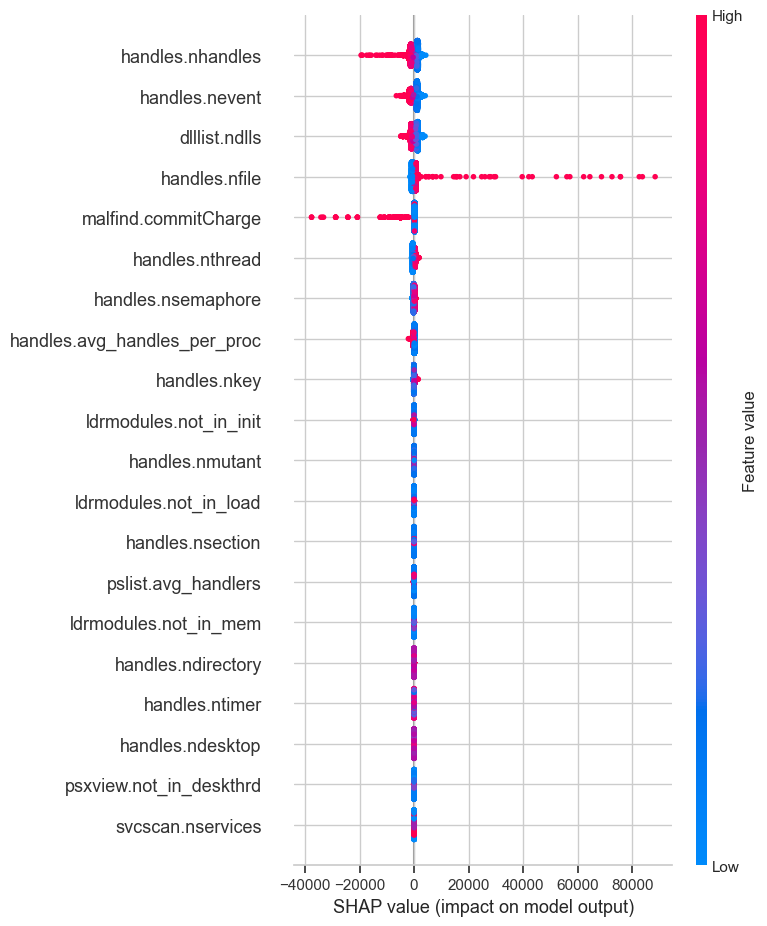

In [ ]:

#list_of_classifiers = ["RandomForest", "LogisticRegression", "DecisionTree"]
#iterate over above list to see all results eg:
#for classifier in list_of_classifiers:


# Choose a classifier for SHAP visualization, change this for different models:
clf_to_plot = "LogisticRegression"

if clf_to_plot in shap_values_dict:
    shap_values = shap_values_dict[clf_to_plot]

    print(f"\nGenerating SHAP summary plot for {clf_to_plot}...")

    # Convert SHAP Explanation object to NumPy format:
    if isinstance(shap_values, shap.Explanation):
        shap_values_array = shap_values.values
        feature_names = shap_values.feature_names
    else:
        shap_values_array = shap_values
        feature_names = X_test.columns.tolist()

    # Ensure SHAP values are 2D for summary plot:
    if shap_values_array.ndim == 3:
        shap_values_array = shap_values_array[:, :, 0]

    # Convert X_test to NumPy for SHAP compatibility:
    X_test_np = X_test.to_numpy()

    # Add Title to the Plot:
    plt.figure(figsize=(12, 8))
    plt.title(f"SHAP Summary Plot - {clf_to_plot} Model", fontsize=14, fontweight="bold")
    shap.summary_plot(shap_values_array, X_test_np, feature_names=feature_names, show=False)
    plt.show()

else:
    print(f"SHAP values not found for {clf_to_plot}. Ensure training completed successfully.")

Cell 7:
Adversarial Sample Generation (FGSM)

Loads pre-trained models and generates adversarial samples for 100 "Conti" samples using Fast Gradient Sign Method (FGSM), targeting "Benign".

Evaluates model performance on these samples.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import joblib
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import SklearnClassifier


# Define tasks and classifiers to evaluate - not relevent here currently- but can be changed to other classifier type for analysis of transferability eg the category classifiers 

tasks = ['variant']

#classifiers = ['LogisticRegression', 'RandomForest', 'KNN', 'DecisionTree']

classifiers = ['LogisticRegression', 'DecisionTree']

# Load pre-trained models saved from cell 5 ( can use directly too)
trained_models = {
    task: {clf: joblib.load(f"{clf}_AA_model.pkl") for clf in classifiers}
    for task in tasks
}

# Adversarial Sample Generation - use random seed for reproducibility
np.random.seed(42)

# Select 100 random Conti samples from test set
conti_encoded = le_catname.transform(['Conti'])[0]
conti_indices = test_df[test_df['category_name_encoded'] == conti_encoded].index
if len(conti_indices) < 100:
    print(f"Warning: Only {len(conti_indices)} Conti samples available. Using all available samples.")
    selected_indices = conti_indices
else:
    selected_indices = np.random.choice(conti_indices, 100, replace=False)

# Get the selected samples
X_test_conti = X_test.loc[selected_indices]
y_test_conti_variant = test_df.loc[selected_indices, 'category_name_encoded']

##debugging - decode the labels and make sure are still conti samples that are selected ##
"""
print("Conti encoded value:", conti_encoded)
print("y_test_conti_variant values:", y_test_conti_variant.unique())
print("Decoded true labels:", le_catname.inverse_transform(y_test_conti_variant))"
"""

y_test_conti_binary = test_df.loc[selected_indices, 'Class_encoded']
y_test_conti_category = test_df.loc[selected_indices, 'category_encoded']

# Keep track of the original samples - for analysis of adversarial samples vs the original samples
original_category = test_df.loc[selected_indices, 'Category']
original_class = test_df.loc[selected_indices, 'Class']
original_category_type = test_df.loc[selected_indices, 'category']
original_category_name = test_df.loc[selected_indices, 'category_name']

# Save original samples to CSV - for analysis of adversarial samples vs the original samples
original_samples_df = X_test_conti.copy()
original_samples_df['Category'] = original_category.values
original_samples_df['Class'] = original_class.values
original_samples_df['category'] = original_category_type.values
original_samples_df['category_name'] = original_category_name.values
original_samples_df.to_csv("original_fgsm_samples.csv", index=False)

# Define features not to modify - change this per the features identified in the SHAP analysis
features_not_to_modify = [
    "svcscan.nservices", "dlllist.avg_dlls_per_proc", "svcscan.kernel_drivers",
    "handles.nsection", "svcscan.shared_process_services", "malfind.commitCharge"
]

indices_not_to_modify = [X_test.columns.get_loc(feat) for feat in features_not_to_modify]

# Epsilon values to test ( 0.0 used for comparision only)
epsilon_values = [0.0, 0.1]

#not required currently- but can be modified for analysis to the other model types.
source_models = ['variant']

# Iterate over source models (using LogisticRegression for FGSM)
for source_model in source_models:
    scaler = trained_models['variant']['LogisticRegression'].named_steps['scaler']
    logistic_clf = trained_models['variant']['LogisticRegression'].named_steps['clf']
    
    # Scale the Conti samples
    X_test_conti_scaled = scaler.transform(X_test_conti)
    
    # Create SklearnClassifier for ART
    classifier = SklearnClassifier(model=logistic_clf)
    
    # Target 'Benign' for adversarial attack
    benign_encoded = le_catname.transform(['Benign'])[0]
    y_target = np.full(len(X_test_conti_scaled), benign_encoded)
    
    # Calculate clean accuracy before adversarial attacks
    clean_accuracies = {}
    for task in tasks:
        for clf_name in classifiers:
            model = trained_models[task][clf_name]
            y_pred_clean = model.predict(X_test_conti)
            clean_accuracy = (y_pred_clean == y_test_conti_variant).mean()
            clean_accuracies[(task, clf_name)] = clean_accuracy
            print(f"Clean Accuracy for {clf_name} on {task} task: {clean_accuracy:.4f}")
    
    # Iterate over epsilon values
    for eps in epsilon_values:
        print(f"\nGenerating adversarial samples with {source_model} LR model, epsilon={eps}")
        
        # Define FGSM attack
        fgsm = FastGradientMethod(estimator=classifier, eps=eps, targeted=True)
        
        # Generate adversarial samples
        X_test_adv_scaled = fgsm.generate(X_test_conti_scaled, y=y_target)
        
        # Restrict perturbation for features not to modify
        perturbation = X_test_adv_scaled - X_test_conti_scaled
        perturbation[:, indices_not_to_modify] = 0
        X_test_adv_scaled = X_test_conti_scaled + perturbation
        
        # Inverse transform to original space
        X_test_adv_raw = scaler.inverse_transform(X_test_adv_scaled)
        
        # Convert to DataFrame
        X_test_adv_df = pd.DataFrame(X_test_adv_raw, columns=feature_cols)
        X_test_adv_df['Category'] = original_category.values
        X_test_adv_df['Class'] = original_class.values
        
        # Define column order
        columns_order = ['Category'] + feature_cols + ['Class']
        X_test_adv_df = X_test_adv_df[columns_order]
        
        # Save adversarial samples
        X_test_adv_df.to_csv(f"modified_fgsm_samples_{source_model}_eps_{eps}.csv", index=False)
        
        # Evaluate adversarial samples
        misclassification_results = []
        X_test_adv_features_only = X_test_adv_df[feature_cols]
        
        for task in tasks:
            print(f"\nEvaluating on {task} classification (Source: {source_model}, Epsilon: {eps})")
            for clf_name in classifiers:
                model = trained_models[task][clf_name]
                y_pred_adv = model.predict(X_test_adv_features_only)
                
                # Calculate metrics
                adv_accuracy = (y_pred_adv == y_test_conti_variant).mean()
                clean_accuracy = clean_accuracies[(task, clf_name)]
                accuracy_drop = clean_accuracy - adv_accuracy
                print(f"Adversarial Accuracy for {clf_name}: {adv_accuracy:.4f}")
                print(f"Accuracy Drop for {clf_name}: {accuracy_drop:.4f}")
                
                evasion_count = sum(y_pred_adv != y_test_conti_variant)
                print(f"Total number of evasion samples for {clf_name}: {evasion_count}")
                
                benign_misclassified = sum(y_pred_adv == benign_encoded)
                print(f"Number of Conti samples misclassified as Benign: {benign_misclassified}")
                
                # Prediction distribution
                print(f"\nPrediction Distribution for {clf_name} on {task} task:")
                pred_counts = pd.Series(y_pred_adv).value_counts()
                pred_dist = pd.DataFrame({
                    'Variant': le_catname.inverse_transform(pred_counts.index),
                    'Count': pred_counts.values
                })
                print(pred_dist.to_string(index=False))
                
                # Store results
                for variant, count in zip(le_catname.inverse_transform(pred_counts.index), pred_counts.values):
                    misclassification_results.append({
                        'Source_Model': source_model,
                        'Epsilon': eps,
                        'Task': task,
                        'Eval_Model': clf_name,
                        'Variant': variant,
                        'Count': count,
                        'Evasion_Count': evasion_count,
                        'Benign_Count': benign_misclassified if variant == 'Benign' else 0,
                        'Clean_Accuracy': clean_accuracy,
                        'Adversarial_Accuracy': adv_accuracy,
                        'Accuracy_Drop': accuracy_drop
                    })
        
        # Save misclassification distribution
        misclassification_df = pd.DataFrame(misclassification_results)
        csv_filename = f"misclassification_distribution_{source_model}_eps_{eps}.csv"
        misclassification_df.to_csv(csv_filename, index=False)
        print(f"\nMisclassification distribution saved to '{csv_filename}'")


Clean Accuracy for LogisticRegression on variant task: 0.1000
Clean Accuracy for DecisionTree on variant task: 0.0000

Generating adversarial samples with variant LR model, epsilon=0.0

Evaluating on variant classification (Source: variant, Epsilon: 0.0)
Adversarial Accuracy for LogisticRegression: 0.1000
Accuracy Drop for LogisticRegression: 0.0000
Total number of evasion samples for LogisticRegression: 90
Number of Conti samples misclassified as Benign: 0

Prediction Distribution for LogisticRegression on variant task:
     Variant  Count
      Emotet     21
 Transponder     14
       Conti     10
        Maze     10
       Shade     10
     Refroso      9
        Zeus      9
       Gator      6
180solutions      5
        TIBS      3
        Scar      2
        Pysa      1
Adversarial Accuracy for DecisionTree: 0.0000
Accuracy Drop for DecisionTree: 0.0000
Total number of evasion samples for DecisionTree: 100
Number of Conti samples misclassified as Benign: 0

Prediction Distributio

Cell 8:
As Above- With Visualisations

Clean Accuracy for LogisticRegression on variant task: 0.1000
Clean Accuracy for DecisionTree on variant task: 0.0000

Generating adversarial samples with variant LR model, epsilon=0.0

Evaluating on variant classification (Source: variant, Epsilon: 0.0)
Adversarial Accuracy for LogisticRegression: 0.1000
Accuracy Drop for LogisticRegression: 0.0000
Confusion matrix shape: (16, 16)
Row sums: [  0   0   0   0 100   0   0   0   0   0   0   0   0   0   0   0]


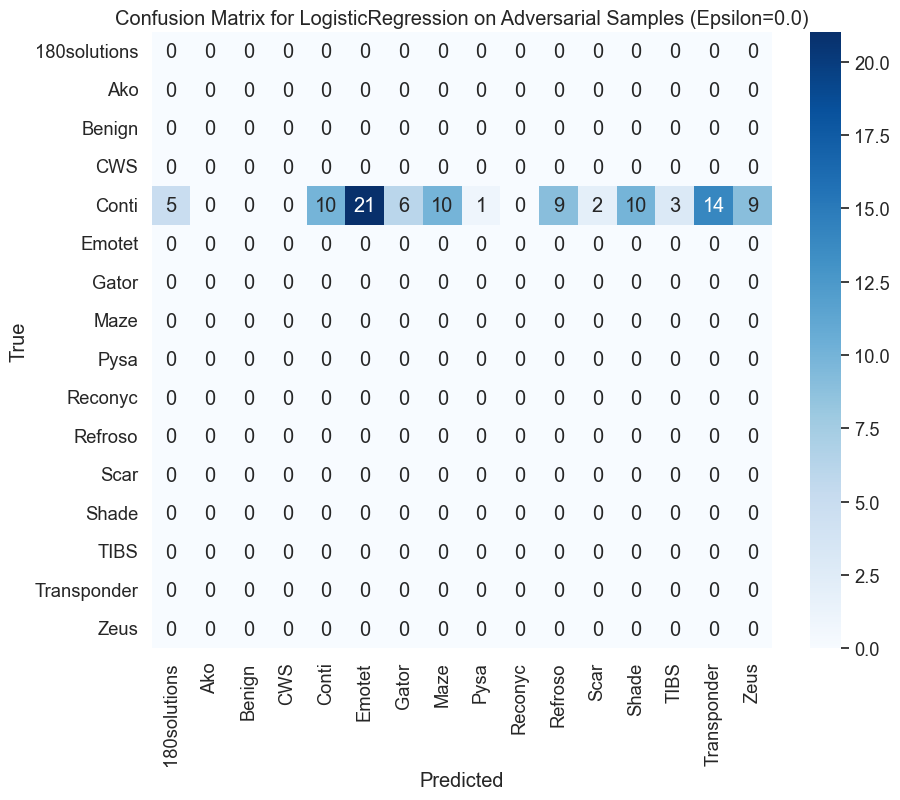

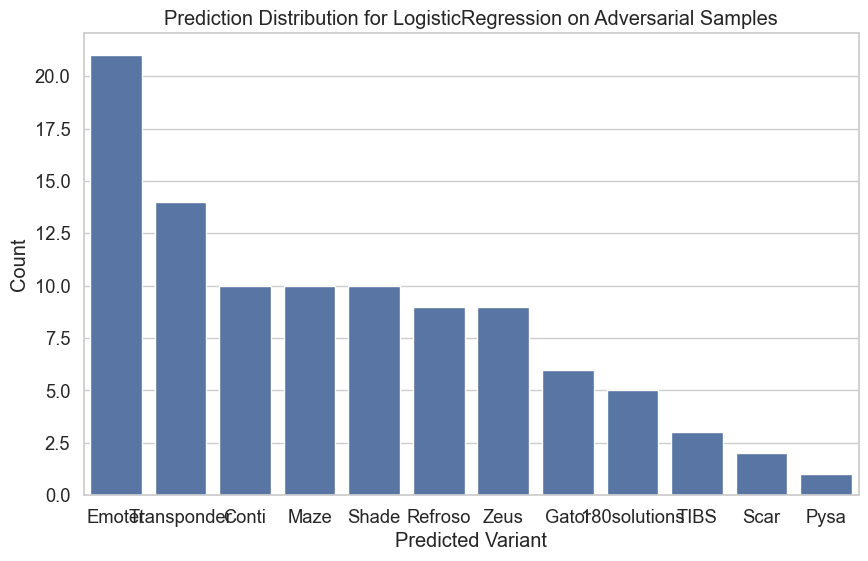

Adversarial Accuracy for DecisionTree: 0.0000
Accuracy Drop for DecisionTree: 0.0000
Confusion matrix shape: (16, 16)
Row sums: [  0   0   0   0 100   0   0   0   0   0   0   0   0   0   0   0]


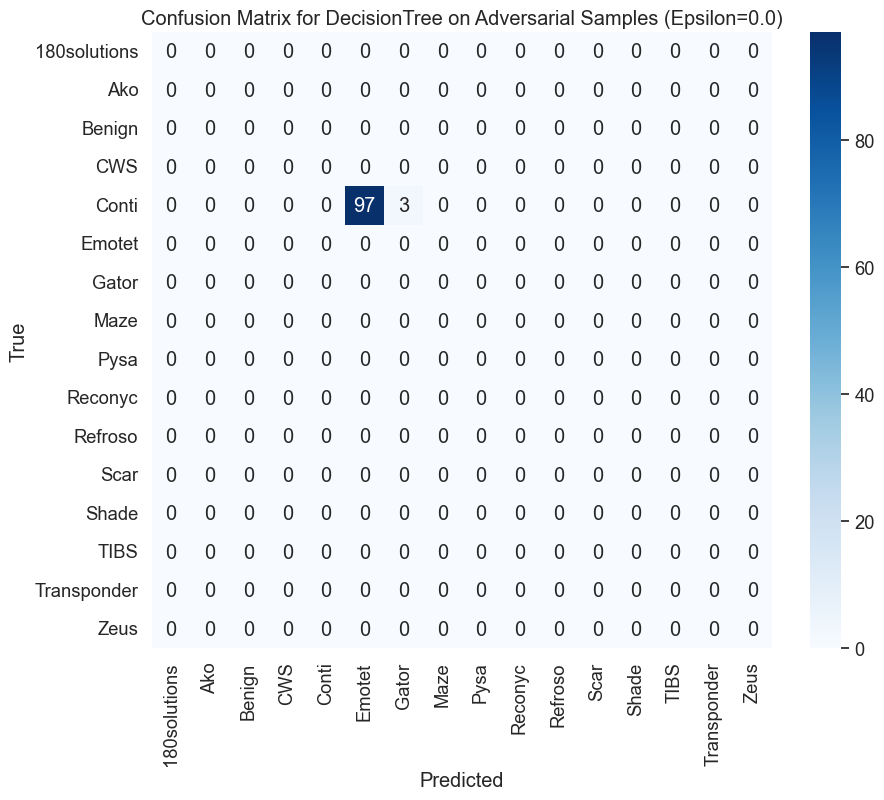

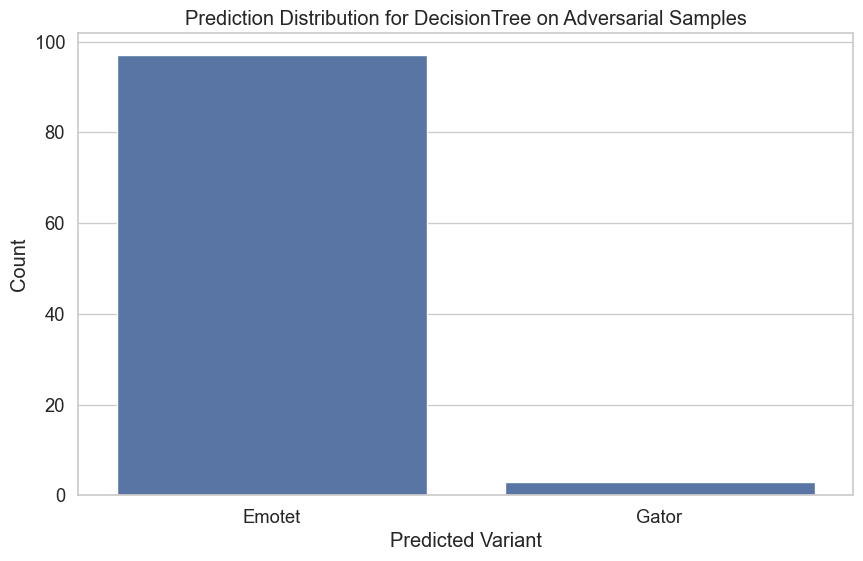


Misclassification distribution saved to 'misclassification_distribution_variant_eps_0.0.csv'

Generating adversarial samples with variant LR model, epsilon=0.1

Evaluating on variant classification (Source: variant, Epsilon: 0.1)
Adversarial Accuracy for LogisticRegression: 0.0100
Accuracy Drop for LogisticRegression: 0.0900
Confusion matrix shape: (16, 16)
Row sums: [  0   0   0   0 100   0   0   0   0   0   0   0   0   0   0   0]


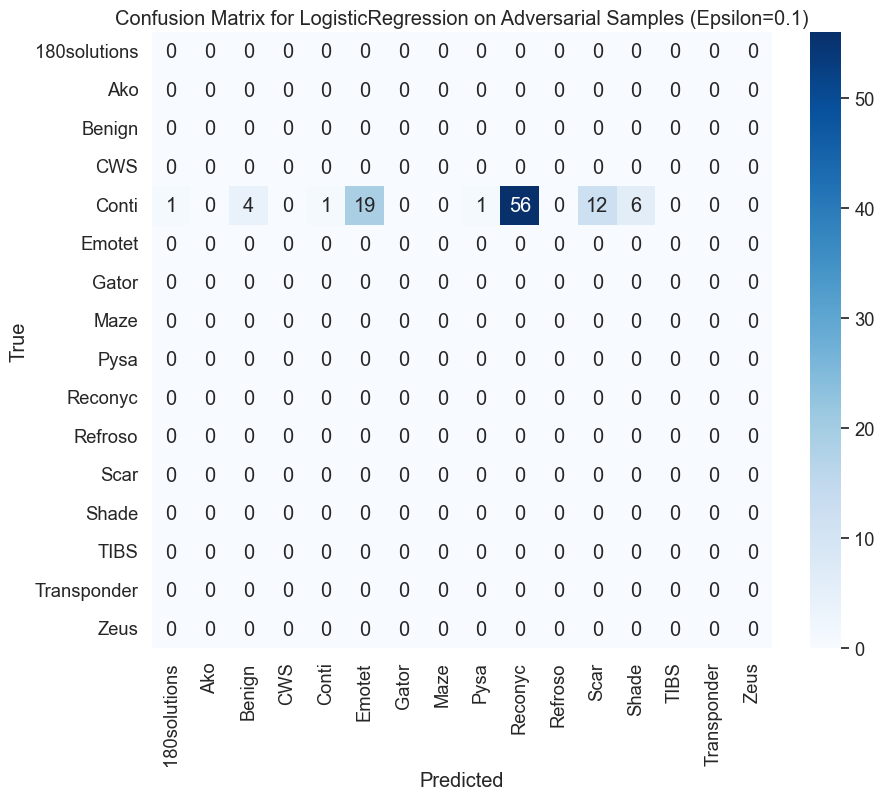

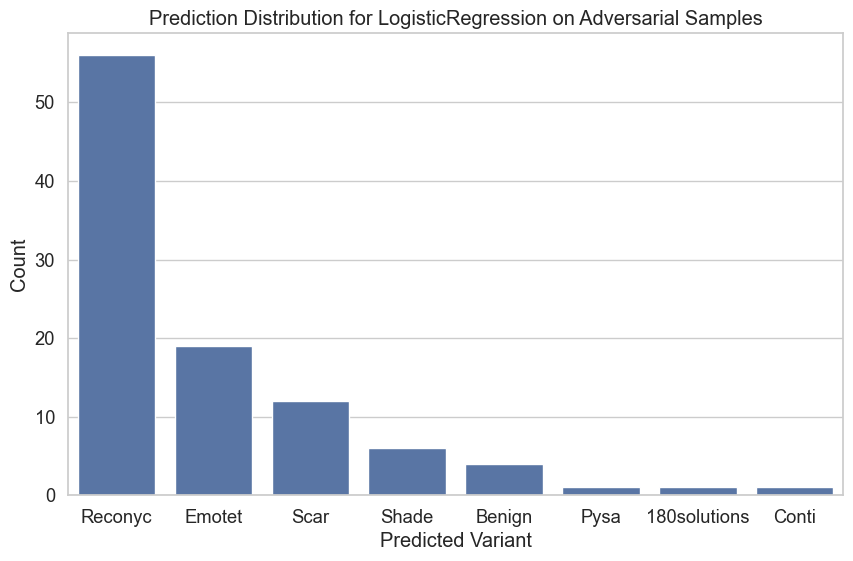

Adversarial Accuracy for DecisionTree: 0.0000
Accuracy Drop for DecisionTree: 0.0000
Confusion matrix shape: (16, 16)
Row sums: [  0   0   0   0 100   0   0   0   0   0   0   0   0   0   0   0]


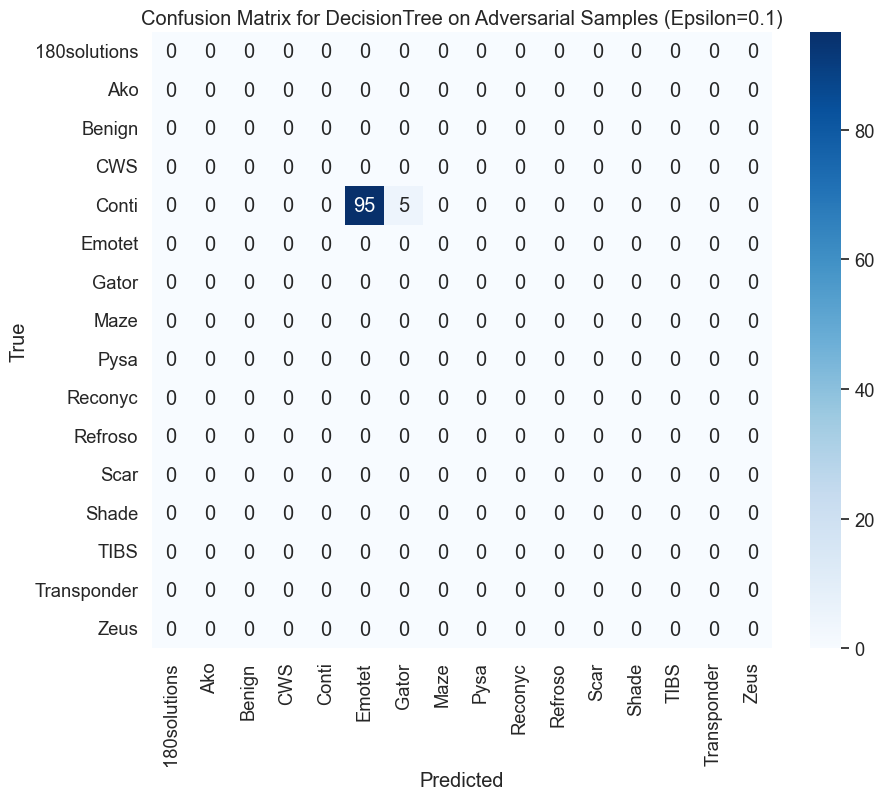

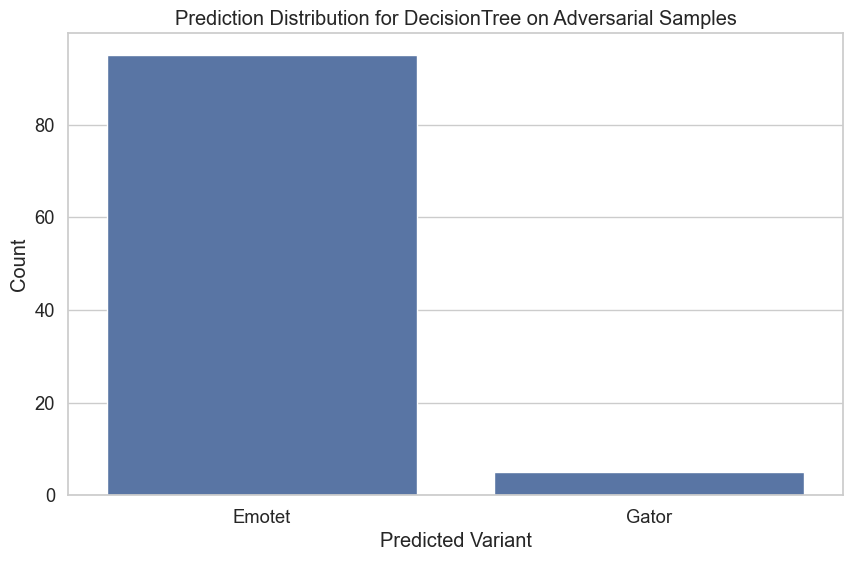


Misclassification distribution saved to 'misclassification_distribution_variant_eps_0.1.csv'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import SklearnClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Define tasks and classifiers to evaluate
tasks = ['variant']
classifiers = ['LogisticRegression', 'DecisionTree']

# Load pre-trained models saved from Code 1
trained_models = {
    task: {clf: joblib.load(f"{clf}_AA_model.pkl") for clf in classifiers}
    for task in tasks
}

# Adversarial Sample Generation Setup
np.random.seed(42)

# Select 100 random Conti samples from test set
conti_encoded = le_catname.transform(['Conti'])[0]
conti_indices = test_df[test_df['category_name_encoded'] == conti_encoded].index
if len(conti_indices) < 100:
    print(f"Warning: Only {len(conti_indices)} Conti samples available. Using all available samples.")
    selected_indices = conti_indices
else:
    selected_indices = np.random.choice(conti_indices, 100, replace=False)

# Get the selected samples
X_test_conti = X_test.loc[selected_indices]
y_test_conti_variant = test_df.loc[selected_indices, 'category_name_encoded']


y_test_conti_binary = test_df.loc[selected_indices, 'Class_encoded']
y_test_conti_category = test_df.loc[selected_indices, 'category_encoded']
original_category = test_df.loc[selected_indices, 'Category']
original_class = test_df.loc[selected_indices, 'Class']
original_category_type = test_df.loc[selected_indices, 'category']
original_category_name = test_df.loc[selected_indices, 'category_name']

# Save original samples to CSV (unchanged)
original_samples_df = X_test_conti.copy()
original_samples_df['Category'] = original_category.values
original_samples_df['Class'] = original_class.values
original_samples_df['category'] = original_category_type.values
original_samples_df['category_name'] = original_category_name.values
original_samples_df.to_csv("original_fgsm_samples.csv", index=False)

# Define features not to modify (unchanged)
features_not_to_modify = [
    "svcscan.nservices", "dlllist.avg_dlls_per_proc", "svcscan.kernel_drivers",
    "handles.nsection", "svcscan.shared_process_services", "malfind.commitCharge"
]
indices_not_to_modify = [X_test.columns.get_loc(feat) for feat in features_not_to_modify]

# Epsilon values to test
epsilon_values = [0.0, 0.1]
source_models = ['variant']

# Iterate over source models
for source_model in source_models:
    scaler = trained_models['variant']['LogisticRegression'].named_steps['scaler']
    logistic_clf = trained_models['variant']['LogisticRegression'].named_steps['clf']
    
    # Scale the Conti samples
    X_test_conti_scaled = scaler.transform(X_test_conti)
    
    # Create SklearnClassifier for ART
    classifier = SklearnClassifier(model=logistic_clf)
    
    # Target 'Benign' for adversarial attack
    benign_encoded = le_catname.transform(['Benign'])[0]
    y_target = np.full(len(X_test_conti_scaled), benign_encoded)
    
    # Calculate clean accuracy (unchanged)
    clean_accuracies = {}
    for task in tasks:
        for clf_name in classifiers:
            model = trained_models[task][clf_name]
            y_pred_clean = model.predict(X_test_conti)
            clean_accuracy = (y_pred_clean == y_test_conti_variant).mean()
            clean_accuracies[(task, clf_name)] = clean_accuracy
            print(f"Clean Accuracy for {clf_name} on {task} task: {clean_accuracy:.4f}")
    
    # Iterate over epsilon values
    for eps in epsilon_values:
        print(f"\nGenerating adversarial samples with {source_model} LR model, epsilon={eps}")
        
        # Define FGSM attack (unchanged)
        fgsm = FastGradientMethod(estimator=classifier, eps=eps, targeted=True)
        
        # Generate adversarial samples (unchanged)
        X_test_adv_scaled = fgsm.generate(X_test_conti_scaled, y=y_target)
        perturbation = X_test_adv_scaled - X_test_conti_scaled
        perturbation[:, indices_not_to_modify] = 0
        X_test_adv_scaled = X_test_conti_scaled + perturbation
        X_test_adv_raw = scaler.inverse_transform(X_test_adv_scaled)
        
        # Convert to DataFrame (unchanged)
        X_test_adv_df = pd.DataFrame(X_test_adv_raw, columns=feature_cols)
        X_test_adv_df['Category'] = original_category.values
        X_test_adv_df['Class'] = original_class.values
        columns_order = ['Category'] + feature_cols + ['Class']
        X_test_adv_df = X_test_adv_df[columns_order]
        
        # Save adversarial samples (unchanged)
        X_test_adv_df.to_csv(f"modified_fgsm_samples_{source_model}_eps_{eps}.csv", index=False)
        
       # Define all labels based on the LabelEncoder (assuming this is defined earlier)
        all_labels = np.arange(len(le_catname.classes_))

        # Evaluate adversarial samples
        misclassification_results = []
        X_test_adv_features_only = X_test_adv_df[feature_cols]

        # Collect data for grouped bar plot
        clean_acc_list = []
        adv_acc_list = []
        clf_names_list = []

        for task in tasks:
            print(f"\nEvaluating on {task} classification (Source: {source_model}, Epsilon: {eps})")
            for clf_name in classifiers:
                model = trained_models[task][clf_name]
                y_pred_adv = model.predict(X_test_adv_features_only)
                
                # Calculate metrics
                adv_accuracy = (y_pred_adv == y_test_conti_variant).mean()
                clean_accuracy = clean_accuracies[(task, clf_name)]
                accuracy_drop = clean_accuracy - adv_accuracy
                print(f"Adversarial Accuracy for {clf_name}: {adv_accuracy:.4f}")
                print(f"Accuracy Drop for {clf_name}: {accuracy_drop:.4f}")
                
                # Store for grouped bar plot
                clean_acc_list.append(clean_accuracy)
                adv_acc_list.append(adv_accuracy)
                clf_names_list.append(clf_name)
                
                # Calculate confusion matrix with all labels
                cm = confusion_matrix(y_test_conti_variant, y_pred_adv, labels=all_labels)
                print(f"Confusion matrix shape: {cm.shape}")
                print(f"Row sums: {cm.sum(axis=1)}")  # Verify true label distribution
                
                # Plot confusion matrix
                plt.figure(figsize=(10, 8))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                            xticklabels=le_catname.classes_, yticklabels=le_catname.classes_)
                plt.title(f'Confusion Matrix for {clf_name} on Adversarial Samples (Epsilon={eps})')
                plt.xlabel('Predicted')
                plt.ylabel('True')
                plt.show()
                
                # Prediction distribution bar plot
                pred_counts = pd.Series(y_pred_adv).value_counts()
                pred_dist = pd.DataFrame({
                    'Variant': le_catname.inverse_transform(pred_counts.index),
                    'Count': pred_counts.values
                })
                plt.figure(figsize=(10, 6))
                sns.barplot(x='Variant', y='Count', data=pred_dist)
                plt.title(f'Prediction Distribution for {clf_name} on Adversarial Samples')
                plt.xlabel('Predicted Variant')
                plt.ylabel('Count')
                plt.show()
                
                # Store results (unchanged)
                for variant, count in zip(le_catname.inverse_transform(pred_counts.index), pred_counts.values):
                    misclassification_results.append({
                        'Source_Model': source_model,
                        'Epsilon': eps,
                        'Task': task,
                        'Eval_Model': clf_name,
                        'Variant': variant,
                        'Count': count,
                        'Evasion_Count': evasion_count,
                        'Benign_Count': benign_misclassified if variant == 'Benign' else 0,
                        'Clean_Accuracy': clean_accuracy,
                        'Adversarial_Accuracy': adv_accuracy,
                        'Accuracy_Drop': accuracy_drop
                    })
        
        # Save misclassification distribution (unchanged)
        misclassification_df = pd.DataFrame(misclassification_results)
        csv_filename = f"misclassification_distribution_{source_model}_eps_{eps}.csv"
        misclassification_df.to_csv(csv_filename, index=False)
        print(f"\nMisclassification distribution saved to '{csv_filename}'")

Cell 9:
Adversarial sample generation for Adversarial training
Purpose: Generates 500 adversarial malware samples each from training and test sets using untargeted FGSM

In [ ]:
# Adversarial Training: 
# Step one: Sample generation.

# 1. Split dataset into training and test set- per the above split
# 2. select 1000 training samples, 500 test samples which are all != benign
# 3. apply untarget fgsm to the samples (modifying all features) using the linear regression model which was trained and saved previously.
# 4. output: 2 csv files, training_adversarial_set and testing_adversarial_set


# Adversarial Sample Generation Setup
np.random.seed(42)

# Function to generate adversarial samples
def generate_adversarial_samples(df, X_data, source_model, epsilon, scaler, classifier, feature_cols, output_prefix):
    # Select 500 random malware samples (excluding benign)
    malware_indices = df[df['Class'] != 'Benign'].index
    if len(malware_indices) < 500:
        print(f"Warning: Only {len(malware_indices)} malware samples available in {output_prefix}. Using all available samples.")
        selected_indices = malware_indices
    else:
        selected_indices = np.random.choice(malware_indices, 500, replace=False)

    # Get selected samples
    X_malware = X_data.loc[selected_indices]
    original_category = df.loc[selected_indices, 'Category']  
    original_class = df.loc[selected_indices, 'Class']

    # Save original samples
    original_samples_df = X_malware.copy()
    original_samples_df['Category'] = original_category.values
    original_samples_df['Class'] = original_class.values
    columns_order = ['Category'] + feature_cols + ['Class']
    original_samples_df = original_samples_df[columns_order]
    original_samples_df.to_csv(f"original_fgsm_samples_{output_prefix}.csv", index=False)

    # Scale the malware samples
    X_malware_scaled = scaler.transform(X_malware)

    # Define FGSM attack (untargeted)
    fgsm = FastGradientMethod(estimator=classifier, eps=epsilon, targeted=False)

    # Generate adversarial samples
    X_adv_scaled = fgsm.generate(X_malware_scaled)

    # Inverse transform to original space
    X_adv_raw = scaler.inverse_transform(X_adv_scaled)

    # Convert to DataFrame
    X_adv_df = pd.DataFrame(X_adv_raw, columns=feature_cols)
    X_adv_df['Category'] = original_category.values
    X_adv_df['Class'] = original_class.values
    X_adv_df = X_adv_df[columns_order]

    # Save adversarial samples
    X_adv_df.to_csv(f"modified_fgsm_samples_{output_prefix}_eps_{epsilon}.csv", index=False)
    print(f"Adversarial samples saved to 'modified_fgsm_samples_{output_prefix}_eps_{epsilon}.csv'")

# Load pre-trained Logistic Regression model for FGSM (variant task)
scaler = trained_models['variant']['LogisticRegression'].named_steps['scaler']
logistic_clf = trained_models['variant']['LogisticRegression'].named_steps['clf']
classifier = SklearnClassifier(model=logistic_clf)

# Parameters
epsilon = 0.01
source_model = 'variant'

# Generate adversarial samples from training set (for retraining)
print("\nGenerating adversarial samples from training set...")
generate_adversarial_samples(
    df=train_df,
    X_data=X_train,
    source_model=source_model,
    epsilon=epsilon,
    scaler=scaler,
    classifier=classifier,
    feature_cols=feature_cols,
    output_prefix="training"
)

# Generate adversarial samples from test set (for evaluation)
print("\nGenerating adversarial samples from test set...")
generate_adversarial_samples(
    df=test_df,
    X_data=X_test,
    source_model=source_model,
    epsilon=epsilon,
    scaler=scaler,
    classifier=classifier,
    feature_cols=feature_cols,
    output_prefix="test"
)


Generating adversarial samples from training set...
Adversarial samples saved to 'modified_fgsm_samples_training_eps_0.01.csv'

Generating adversarial samples from test set...
Adversarial samples saved to 'modified_fgsm_samples_test_eps_0.01.csv'


In [ ]:
#same process as above, but these changes:
# 200 random ( random state 42) samples from  each variant is included in the training set instead of just random malware samples
# an equal number of benign samples are added to the adversarial test set ( unmodified) to see if can still identfy the benign samples under adversarial attack conditions.

import numpy as np
import pandas as pd
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import SklearnClassifier

# Adversarial Sample Generation Setup
np.random.seed(42)

# Function to generate adversarial training samples
def generate_adversarial_training_samples(df, X_data, source_model, epsilon, scaler, classifier, feature_cols):
    """
    Generate adversarial samples for the training set by selecting 200 samples per malware variant.
    
    Parameters:
    - df: DataFrame containing the dataset metadata (e.g., 'Class', 'category_name')
    - X_data: Feature data corresponding to df
    - source_model: Identifier for the source model (e.g., 'variant')
    - epsilon: Perturbation magnitude for FGSM
    - scaler: Pre-trained scaler object
    - classifier: Pre-trained classifier wrapped with SklearnClassifier
    - feature_cols: List of feature column names
    """
    # Identify malware variants (excluding 'Benign')
    malware_variants = df[df['Class'] == 'Malware']['category_name'].unique()
    
    selected_indices = []
    for variant in malware_variants:
        variant_indices = df[df['category_name'] == variant].index
        if len(variant_indices) < 200:
            print(f"Warning: Only {len(variant_indices)} samples available for variant {variant}. Using all available samples.")
            selected_indices.extend(variant_indices)
        else:
            selected_indices.extend(np.random.choice(variant_indices, 200, replace=False))
    
    # Get selected samples
    X_selected = X_data.loc[selected_indices]
    original_category = df.loc[selected_indices, 'Category']
    original_class = df.loc[selected_indices, 'Class']
    
    # Save original samples (optional, for reference)
    original_samples_df = X_selected.copy()
    original_samples_df['Category'] = original_category.values
    original_samples_df['Class'] = original_class.values
    columns_order = ['Category'] + feature_cols + ['Class']
    original_samples_df = original_samples_df[columns_order]
    original_samples_df.to_csv("original_training_1.csv", index=False)
    
    # Scale the selected samples
    X_selected_scaled = scaler.transform(X_selected)
    
    # Define FGSM attack (untargeted)
    fgsm = FastGradientMethod(estimator=classifier, eps=epsilon, targeted=False)
    
    # Generate adversarial samples
    X_adv_scaled = fgsm.generate(X_selected_scaled)
    
    # Inverse transform to original space
    X_adv_raw = scaler.inverse_transform(X_adv_scaled)
    
    # Convert to DataFrame
    X_adv_df = pd.DataFrame(X_adv_raw, columns=feature_cols)
    X_adv_df['Category'] = original_category.values
    X_adv_df['Class'] = original_class.values
    X_adv_df = X_adv_df[columns_order]
    
    # Save adversarial samples
    X_adv_df.to_csv("training_1.csv", index=False)
    print("Adversarial training samples saved to 'training_1.csv'")

# Function to generate adversarial test set
def generate_adversarial_test_set(df, X_data, source_model, epsilon, scaler, classifier, feature_cols):
    """
    Generate an adversarial test set with 500 perturbed malware samples and 500 unmodified benign samples.
    
    Parameters:
    - df: DataFrame containing the dataset metadata (e.g., 'Class')
    - X_data: Feature data corresponding to df
    - source_model: Identifier for the source model (e.g., 'variant')
    - epsilon: Perturbation magnitude for FGSM
    - scaler: Pre-trained scaler object
    - classifier: Pre-trained classifier wrapped with SklearnClassifier
    - feature_cols: List of feature column names
    """
    # Select 500 random malware samples
    malware_indices = df[df['Class'] == 'Malware'].index
    if len(malware_indices) < 500:
        print(f"Warning: Only {len(malware_indices)} malware samples available in test set. Using all available samples.")
        selected_malware_indices = malware_indices
    else:
        selected_malware_indices = np.random.choice(malware_indices, 500, replace=False)
    
    # Select 500 random benign samples
    benign_indices = df[df['Class'] == 'Benign'].index
    if len(benign_indices) < 500:
        print(f"Warning: Only {len(benign_indices)} benign samples available in test set. Using all available samples.")
        selected_benign_indices = benign_indices
    else:
        selected_benign_indices = np.random.choice(benign_indices, 500, replace=False)
    
    # Get selected malware samples
    X_malware = X_data.loc[selected_malware_indices]
    original_category_malware = df.loc[selected_malware_indices, 'Category']
    original_class_malware = df.loc[selected_malware_indices, 'Class']
    
    # Scale the malware samples
    X_malware_scaled = scaler.transform(X_malware)
    
    # Define FGSM attack (untargeted)
    fgsm = FastGradientMethod(estimator=classifier, eps=epsilon, targeted=False)
    
    # Generate adversarial samples for malware
    X_adv_malware_scaled = fgsm.generate(X_malware_scaled)
    
    # Inverse transform to original space
    X_adv_malware_raw = scaler.inverse_transform(X_adv_malware_scaled)
    
    # Convert to DataFrame
    X_adv_malware_df = pd.DataFrame(X_adv_malware_raw, columns=feature_cols)
    X_adv_malware_df['Category'] = original_category_malware.values
    X_adv_malware_df['Class'] = original_class_malware.values
    
    # Get selected benign samples (unmodified)
    X_benign = X_data.loc[selected_benign_indices]
    original_category_benign = df.loc[selected_benign_indices, 'Category']
    original_class_benign = df.loc[selected_benign_indices, 'Class']
    
    # Convert to DataFrame
    X_benign_df = pd.DataFrame(X_benign, columns=feature_cols)
    X_benign_df['Category'] = original_category_benign.values
    X_benign_df['Class'] = original_class_benign.values
    
    # Combine adversarial malware and unmodified benign samples
    adversarial_test_df = pd.concat([X_adv_malware_df, X_benign_df], ignore_index=True)
    columns_order = ['Category'] + feature_cols + ['Class']
    adversarial_test_df = adversarial_test_df[columns_order]
    
    # Save the combined adversarial test set
    adversarial_test_df.to_csv("test_1.csv", index=False)
    print("Adversarial test set saved to 'test_1.csv'")

# Load pre-trained Logistic Regression model for FGSM (variant task)
scaler = trained_models['variant']['LogisticRegression'].named_steps['scaler']
logistic_clf = trained_models['variant']['LogisticRegression'].named_steps['clf']
classifier = SklearnClassifier(model=logistic_clf)

# Parameters
epsilon = 0.01
source_model = 'variant'

# Generate adversarial samples from training set (for retraining)
print("\nGenerating adversarial samples from training set...")
generate_adversarial_training_samples(
    df=train_df,
    X_data=X_train,
    source_model=source_model,
    epsilon=epsilon,
    scaler=scaler,
    classifier=classifier,
    feature_cols=feature_cols
)

# Generate adversarial test set (for evaluation)
print("\nGenerating adversarial test set...")
generate_adversarial_test_set(
    df=test_df,
    X_data=X_test,
    source_model=source_model,
    epsilon=epsilon,
    scaler=scaler,
    classifier=classifier,
    feature_cols=feature_cols
)









Generating adversarial samples from training set...
Adversarial training samples saved to 'training_1.csv'

Generating adversarial test set...
Adversarial test set saved to 'test_1.csv'


Cell 10:
Adversarial training:

Combines original and adversarial training data, retrains models, and evaluates them on clean and adversarial test sets.



In [ ]:
""" Adversarial Retraining:
Model performance
Original Models tested on the adeversarial test set, 
models retrainied using hte adversarial training set
retrained models tested on the original and adversarial test sets. """

#Adversarial Retraining


# --- Step 1: Load and Preprocess Adversarial Training and Test Data ---

# Load adversarial training data
#adv_train_df = pd.read_csv(r'./modified_fgsm_samples_training_eps_0.01.csv') # using the previously made adversarial training dataset.
adv_train_df = pd.read_csv(r'./training_1.csv') # using the previously made adversarial training dataset.
adv_train_df.fillna(method="ffill", inplace=True)
adv_train_df["category"] = adv_train_df["Category"].apply(find_category)
adv_train_df["category_name"] = adv_train_df["Category"].apply(find_category_name)
adv_train_df["unique_file_id"] = adv_train_df["Category"].apply(extract_unique_file_id)
adv_train_df['Class_encoded'] = le_class.transform(adv_train_df['Class'])
adv_train_df['category_encoded'] = le_category.transform(adv_train_df['category'])
adv_train_df['category_name_encoded'] = le_catname.transform(adv_train_df['category_name'])
adv_train_df['group_id'] = adv_train_df.apply(lambda row: row['unique_file_id'] if row['Class'] != 'Benign' 
                                              else f"benign_adv_{row.name}", axis=1)

# Combine original training data with adversarial training data
adversarialdataset = pd.concat([train_df, adv_train_df], ignore_index=True)
print("Adversarial training set shape (adversarialdataset):", adversarialdataset.shape)

# Load adversarial test samples
#adv_test_df = pd.read_csv(r'./modified_fgsm_samples_test_eps_0.01.csv')
adv_test_df = pd.read_csv(r'./test_1.csv')
adv_test_df.fillna(method="ffill", inplace=True)
adv_test_df["category"] = adv_test_df["Category"].apply(find_category)
adv_test_df["category_name"] = adv_test_df["Category"].apply(find_category_name)
adv_test_df["unique_file_id"] = adv_test_df["Category"].apply(extract_unique_file_id)
adv_test_df['Class_encoded'] = le_class.transform(adv_test_df['Class'])
adv_test_df['category_encoded'] = le_category.transform(adv_test_df['category'])
adv_test_df['category_name_encoded'] = le_catname.transform(adv_test_df['category_name'])
adv_test_df['group_id'] = adv_test_df.apply(lambda row: row['unique_file_id'] if row['Class'] != 'Benign' 
                                            else f"benign_adv_test_{row.name}", axis=1)
print("Adversarial test set shape:", adv_test_df.shape)

# --- Define Tasks and Classifiers ---

# Classification task (focusing on variant classification as an example)
tasks = [
    {'name': 'variant', 'target_col': 'category_name_encoded', 'encoder': le_catname}
]

# Classifier (using Logistic Regression and DT as example)
classifiers = {
    'LogisticRegression': (LogisticRegression(penalty='l2', C=0.5, solver='liblinear', max_iter=1000, random_state=42), True),
    'DecisionTree': (DecisionTreeClassifier(random_state=42), False),   
}

# Parameter grid for hyperparameter tuning - copying from cell 5
param_grids = {
    'LogisticRegression': {'C': [0.1, 0.5, 1]},
    'DecisionTree': {
        'max_depth': [3, 5],
        'min_samples_split': [6, 8],
        'min_samples_leaf': [2, 3]
    }
}

# --- Helper Function --- ( per cell 5)

def get_X_y(df, target_col):
    X = df[feature_cols]  
    y = df[target_col]
    return X, y

# --- Training and Evaluation Loop ---

for task in tasks:
    print(f"\nTraining models for {task['name']} classification...")
    
    # Prepare data
    X_adv, y_adv = get_X_y(adversarialdataset, task['target_col'])
    groups_adv = adversarialdataset['group_id']
    X_test_clean, y_test_clean = get_X_y(test_df, task['target_col'])
    X_test_adv, y_test_adv = get_X_y(adv_test_df, task['target_col'])
    
    for clf_name, (clf_obj, scale_required) in classifiers.items():
        print(f"\nProcessing {clf_name} for {task['name']}...")
        
        # Step 1: Test original model on adversarial test set
        original_model = trained_models[task['name']][clf_name]  # Assumes trained_models is a dict from prior cells
        y_pred_adv_og = original_model.predict(X_test_adv)
        y_pred_adv_og_labels = task['encoder'].inverse_transform(y_pred_adv_og)
        y_test_adv_labels = task['encoder'].inverse_transform(y_test_adv)
        print(f"\nClassification Report for original {clf_name} on adversarial test set:")
        print(classification_report(y_test_adv_labels, y_pred_adv_og_labels, digits=4))
        
        # Step 2: Retrain on combined dataset (adversarialdataset)
        if scale_required:
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('clf', clf_obj)
            ])
            grid = {f'clf__{param}': values for param, values in param_grids[clf_name].items()}
            grid_search_adv = GridSearchCV(pipeline, grid, cv=GroupKFold(n_splits=5),
                                           scoring='accuracy', n_jobs=-1)
            grid_search_adv.fit(X_adv, y_adv, groups=groups_adv)
            best_model_adv = grid_search_adv.best_estimator_
        else:
            grid_search_adv = GridSearchCV(clf_obj, param_grids[clf_name], cv=GroupKFold(n_splits=5),
                                           scoring='accuracy', n_jobs=-1)
            grid_search_adv.fit(X_adv, y_adv, groups=groups_adv)
            best_model_adv = grid_search_adv.best_estimator_
        print(f"Best parameters for {clf_name} on adversarialdataset: {grid_search_adv.best_params_}")
        
        # Save the retrained model
        joblib.dump(best_model_adv, f"adversarially_trained_{clf_name}_{task['name']}_model.pkl")
        print(f"Saved adversarially trained model to adversarially_trained_{clf_name}_{task['name']}_model.pkl")
        
        # Step 3: Test retrained model on clean and adversarial test sets
        # Clean test set
        y_pred_clean_adv = best_model_adv.predict(X_test_clean)
        y_pred_clean_adv_labels = task['encoder'].inverse_transform(y_pred_clean_adv)
        y_test_clean_labels = task['encoder'].inverse_transform(y_test_clean)
        print(f"\nClassification Report for adversarially trained {clf_name} on clean test set:")
        print(classification_report(y_test_clean_labels, y_pred_clean_adv_labels, digits=4))
        
        # Adversarial test set
        y_pred_adv_adv = best_model_adv.predict(X_test_adv)
        y_pred_adv_adv_labels = task['encoder'].inverse_transform(y_pred_adv_adv)
        print(f"\nClassification Report for adversarially trained {clf_name} on adversarial test set:")
        print(classification_report(y_test_adv_labels, y_pred_adv_adv_labels, digits=4))
        
        # Step 4: Evaluate performance
        acc_adv_og = accuracy_score(y_test_adv, y_pred_adv_og)
        acc_clean_adv = accuracy_score(y_test_clean, y_pred_clean_adv)
        acc_adv_adv = accuracy_score(y_test_adv, y_pred_adv_adv)
        
        recall_adv_og = recall_score(y_test_adv, y_pred_adv_og, average='weighted')
        recall_clean_adv = recall_score(y_test_clean, y_pred_clean_adv, average='weighted')
        recall_adv_adv = recall_score(y_test_adv, y_pred_adv_adv, average='weighted')
        
        f1_adv_og = f1_score(y_test_adv, y_pred_adv_og, average='weighted')
        f1_clean_adv = f1_score(y_test_clean, y_pred_clean_adv, average='weighted')
        f1_adv_adv = f1_score(y_test_adv, y_pred_adv_adv, average='weighted')
        
        accuracy_drop_og = acc_adv_og - accuracy_score(y_test_clean, original_model.predict(X_test_clean))  # Assuming prior clean test accuracy available
        accuracy_drop_adv = acc_adv_adv - acc_clean_adv
        
        print(f"\nPerformance Comparison for {clf_name} ({task['name']}):")
        print(f"{'Original Model on Adversarial Test':<40} Accuracy: {acc_adv_og:.4f}, Recall: {recall_adv_og:.4f}, F1: {f1_adv_og:.4f}")
        print(f"{'Adversarially Trained on Clean Test':<40} Accuracy: {acc_clean_adv:.4f}, Recall: {recall_clean_adv:.4f}, F1: {f1_clean_adv:.4f}")
        print(f"{'Adversarially Trained on Adversarial Test':<40} Accuracy: {acc_adv_adv:.4f}, Recall: {recall_adv_adv:.4f}, F1: {f1_adv_adv:.4f}")
        print(f"{'Accuracy Drop (Original, Clean to Adv)':<40} {accuracy_drop_og:.4f}")
        print(f"{'Accuracy Drop (Adv Trained, Clean to Adv)':<40} {accuracy_drop_adv:.4f}")

# Optionally save datasets
adversarialdataset.to_csv("Adversarial_Dataset.csv", index=False)
adv_test_df.to_csv("Adversarial_Test_Dataset.csv", index=False)


C:\Users\MSI\AppData\Local\Temp\ipykernel_16488\2236452035.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  adv_train_df.fillna(method="ffill", inplace=True)
C:\Users\MSI\AppData\Local\Temp\ipykernel_16488\2236452035.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  adv_test_df.fillna(method="ffill", inplace=True)
C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Adversarial training set shape (adversarialdataset): (41199, 64)
Adversarial test set shape: (1000, 64)

Training models for variant classification...

Processing LogisticRegression for variant...

Classification Report for original LogisticRegression on adversarial test set:
              precision    recall  f1-score   support

180solutions     0.0000    0.0000    0.0000        27
         Ako     0.3571    0.3571    0.3571        28
      Benign     1.0000    1.0000    1.0000       500
         CWS     0.1538    0.0588    0.0851        34
       Conti     0.0645    0.0541    0.0588        37
      Emotet     0.1481    0.3333    0.2051        24
       Gator     0.6000    0.5625    0.5806        48
        Maze     0.1389    0.1786    0.1562        28
        Pysa     0.3333    0.0882    0.1395        34
     Reconyc     0.0000    0.0000    0.0000        24
     Refroso     0.1833    0.3929    0.2500        28
        Scar     0.1765    0.1429    0.1579        42
       Shade     0.0

C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best parameters for LogisticRegression on adversarialdataset: {'clf__C': 1}
Saved adversarially trained model to adversarially_trained_LogisticRegression_variant_model.pkl

Classification Report for adversarially trained LogisticRegression on clean test set:
              precision    recall  f1-score   support

180solutions     0.2254    0.0709    0.1079       550
         Ako     0.2280    0.1630    0.1901       540
      Benign     0.9983    0.9995    0.9989      8792
         CWS     0.3952    0.0731    0.1234       670
       Conti     0.1336    0.1095    0.1204       639
      Emotet     0.1256    0.2971    0.1766       488
       Gator     0.5431    0.4672    0.5023       822
        Maze     0.1843    0.2431    0.2097       580
        Pysa     0.2582    0.0872    0.1304       539
     Reconyc     0.3023    0.0228    0.0424       570
     Refroso     0.1953    0.4154    0.2657       520
        Scar     0.2117    0.1867    0.1984       600
       Shade     0.1419    0.1964    0

C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:

Best parameters for DecisionTree on adversarialdataset: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 6}
Saved adversarially trained model to adversarially_trained_DecisionTree_variant_model.pkl

Classification Report for adversarially trained DecisionTree on clean test set:


C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:

              precision    recall  f1-score   support

180solutions     0.0000    0.0000    0.0000       550
         Ako     0.0000    0.0000    0.0000       540
      Benign     0.9999    0.9990    0.9994      8792
         CWS     0.0000    0.0000    0.0000       670
       Conti     0.0000    0.0000    0.0000       639
      Emotet     0.0665    0.9344    0.1241       488
       Gator     0.5337    0.4623    0.4954       822
        Maze     0.0000    0.0000    0.0000       580
        Pysa     0.6230    0.0705    0.1267       539
     Reconyc     0.0000    0.0000    0.0000       570
     Refroso     0.6495    0.3635    0.4661       520
        Scar     0.0000    0.0000    0.0000       600
       Shade     0.0000    0.0000    0.0000       616
        TIBS     0.8195    0.2595    0.3942       420
 Transponder     0.1695    0.1930    0.1805       570
        Zeus     0.0000    0.0000    0.0000       612

    accuracy                         0.5742     17528
   macro avg     0.2413   

Cell 10:

Same as above but with visualisation added.

C:\Users\MSI\AppData\Local\Temp\ipykernel_16488\4063907754.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  adv_train_df.fillna(method="ffill", inplace=True)
C:\Users\MSI\AppData\Local\Temp\ipykernel_16488\4063907754.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  adv_test_df.fillna(method="ffill", inplace=True)


Adversarial training set shape (adversarialdataset): (41199, 64)
Adversarial test set shape: (1000, 64)


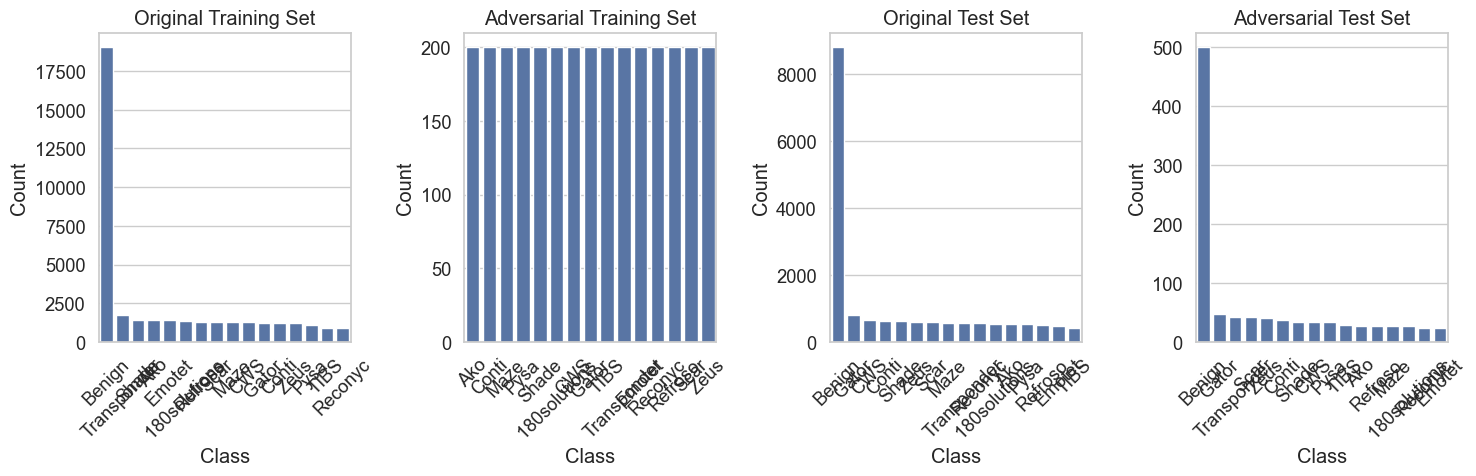


Training models for variant classification...

Processing LogisticRegression for variant...

Classification Report for original LogisticRegression on adversarial test set:
              precision    recall  f1-score   support

180solutions     0.0000    0.0000    0.0000        27
         Ako     0.3571    0.3571    0.3571        28
      Benign     1.0000    1.0000    1.0000       500
         CWS     0.1538    0.0588    0.0851        34
       Conti     0.0645    0.0541    0.0588        37
      Emotet     0.1481    0.3333    0.2051        24
       Gator     0.6000    0.5625    0.5806        48
        Maze     0.1389    0.1786    0.1562        28
        Pysa     0.3333    0.0882    0.1395        34
     Reconyc     0.0000    0.0000    0.0000        24
     Refroso     0.1833    0.3929    0.2500        28
        Scar     0.1765    0.1429    0.1579        42
       Shade     0.0870    0.1765    0.1165        34
        TIBS     0.4286    0.3103    0.3600        29
 Transponder    

C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:

Best parameters for LogisticRegression on adversarialdataset: {'clf__C': 1}
Saved adversarially trained model to adversarially_trained_LogisticRegression_variant_model.pkl

Classification Report for adversarially trained LogisticRegression on clean test set:
              precision    recall  f1-score   support

180solutions     0.2254    0.0709    0.1079       550
         Ako     0.2280    0.1630    0.1901       540
      Benign     0.9983    0.9995    0.9989      8792
         CWS     0.3952    0.0731    0.1234       670
       Conti     0.1336    0.1095    0.1204       639
      Emotet     0.1256    0.2971    0.1766       488
       Gator     0.5431    0.4672    0.5023       822
        Maze     0.1843    0.2431    0.2097       580
        Pysa     0.2582    0.0872    0.1304       539
     Reconyc     0.3023    0.0228    0.0424       570
     Refroso     0.1953    0.4154    0.2657       520
        Scar     0.2117    0.1867    0.1984       600
       Shade     0.1419    0.1964    0

C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:

Best parameters for DecisionTree on adversarialdataset: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 6}
Saved adversarially trained model to adversarially_trained_DecisionTree_variant_model.pkl

Classification Report for adversarially trained DecisionTree on clean test set:


C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:

              precision    recall  f1-score   support

180solutions     0.0000    0.0000    0.0000       550
         Ako     0.0000    0.0000    0.0000       540
      Benign     0.9999    0.9990    0.9994      8792
         CWS     0.0000    0.0000    0.0000       670
       Conti     0.0000    0.0000    0.0000       639
      Emotet     0.0665    0.9344    0.1241       488
       Gator     0.5337    0.4623    0.4954       822
        Maze     0.0000    0.0000    0.0000       580
        Pysa     0.6230    0.0705    0.1267       539
     Reconyc     0.0000    0.0000    0.0000       570
     Refroso     0.6495    0.3635    0.4661       520
        Scar     0.0000    0.0000    0.0000       600
       Shade     0.0000    0.0000    0.0000       616
        TIBS     0.8195    0.2595    0.3942       420
 Transponder     0.1695    0.1930    0.1805       570
        Zeus     0.0000    0.0000    0.0000       612

    accuracy                         0.5742     17528
   macro avg     0.2413   

C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:

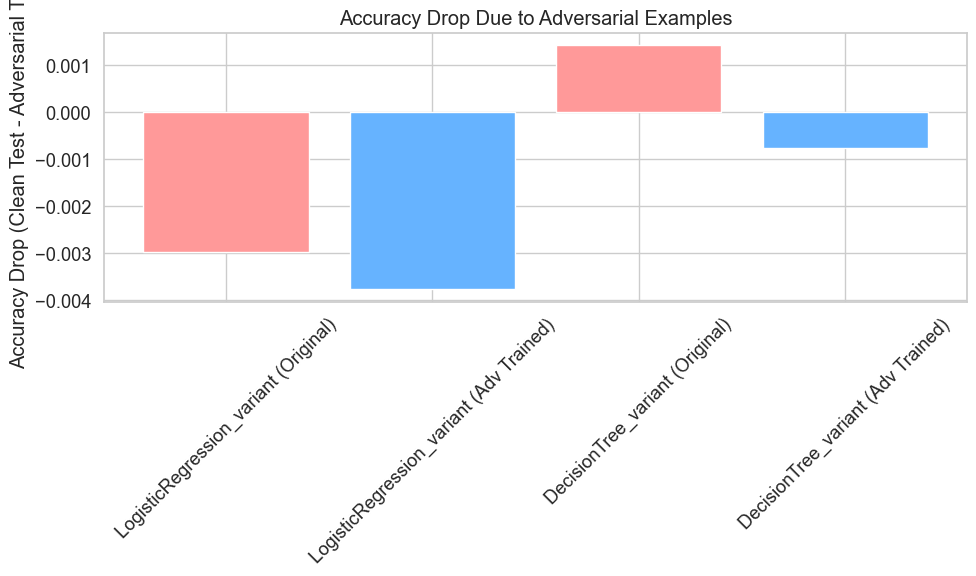

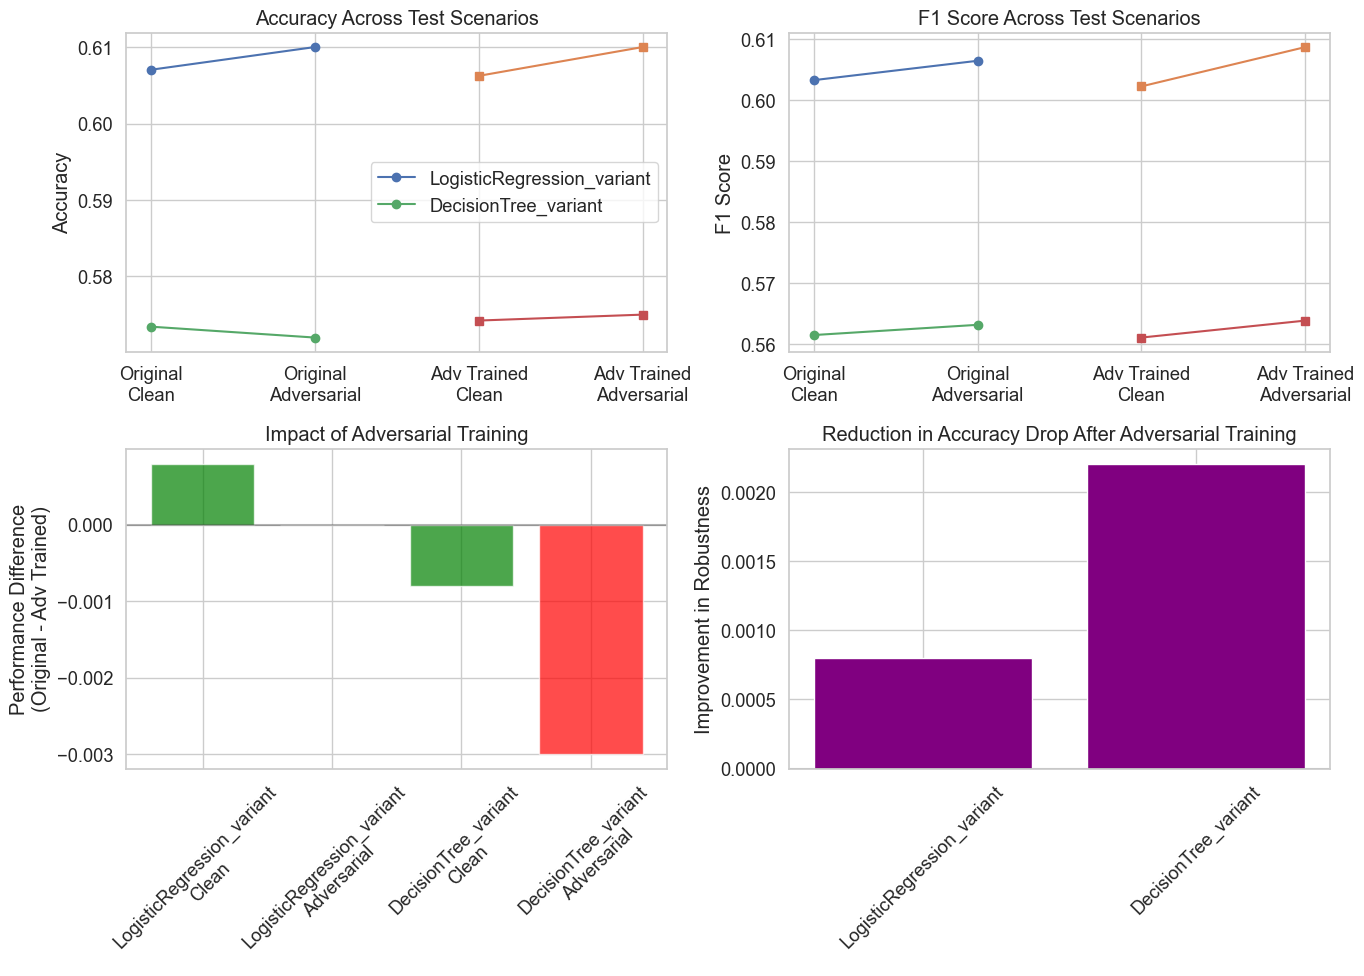

In [ ]:
#visuals
""" Adversarial Retraining:
Model performance
Original Models tested on the adversarial test set, 
models retrained using the adversarial training set
retrained models tested on the original and adversarial test sets. """

#Adversarial Retraining


# Set plot style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

# --- Step 1: Load and Preprocess Adversarial Training and Test Data ---

# Load adversarial training data
adv_train_df = pd.read_csv(r'./modified_fgsm_samples_training_eps_0.01.csv')
#adv_train_df = pd.read_csv(r'./training_1.csv')
adv_train_df.fillna(method="ffill", inplace=True)
adv_train_df["category"] = adv_train_df["Category"].apply(find_category)
adv_train_df["category_name"] = adv_train_df["Category"].apply(find_category_name)
adv_train_df["unique_file_id"] = adv_train_df["Category"].apply(extract_unique_file_id)
adv_train_df['Class_encoded'] = le_class.transform(adv_train_df['Class'])
adv_train_df['category_encoded'] = le_category.transform(adv_train_df['category'])
adv_train_df['category_name_encoded'] = le_catname.transform(adv_train_df['category_name'])
adv_train_df['group_id'] = adv_train_df.apply(lambda row: row['unique_file_id'] if row['Class'] != 'Benign' 
                                              else f"benign_adv_{row.name}", axis=1)

# Combine original training data with adversarial training data
adversarialdataset = pd.concat([train_df, adv_train_df], ignore_index=True)
print("Adversarial training set shape (adversarialdataset):", adversarialdataset.shape)

# Load adversarial test samples
adv_test_df = pd.read_csv(r'./modified_fgsm_samples_test_eps_0.01.csv')
#adv_test_df = pd.read_csv(r'./test_1.csv')
adv_test_df.fillna(method="ffill", inplace=True)
adv_test_df["category"] = adv_test_df["Category"].apply(find_category)
adv_test_df["category_name"] = adv_test_df["Category"].apply(find_category_name)
adv_test_df["unique_file_id"] = adv_test_df["Category"].apply(extract_unique_file_id)
adv_test_df['Class_encoded'] = le_class.transform(adv_test_df['Class'])
adv_test_df['category_encoded'] = le_category.transform(adv_test_df['category'])
adv_test_df['category_name_encoded'] = le_catname.transform(adv_test_df['category_name'])
adv_test_df['group_id'] = adv_test_df.apply(lambda row: row['unique_file_id'] if row['Class'] != 'Benign' 
                                            else f"benign_adv_test_{row.name}", axis=1)
print("Adversarial test set shape:", adv_test_df.shape)

# Visualize dataset composition
def plot_dataset_composition(datasets, titles):
    """Plot class distribution in multiple datasets."""
    fig, axes = plt.subplots(1, len(datasets), figsize=(15, 5))
    
    for i, (df, title) in enumerate(zip(datasets, titles)):
        if 'category_name' in df.columns:
            class_counts = df['category_name'].value_counts()
        else:
            class_counts = df['Class'].value_counts()
        
        sns.barplot(x=class_counts.index, y=class_counts.values, ax=axes[i])
        axes[i].set_title(title)
        axes[i].set_ylabel('Count')
        axes[i].set_xlabel('Class')
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('dataset_composition.png', dpi=300, bbox_inches='tight')
    plt.show()

# Call visualization function
plot_dataset_composition(
    [train_df, adv_train_df, test_df, adv_test_df],
    ['Original Training Set', 'Adversarial Training Set', 'Original Test Set', 'Adversarial Test Set']
)

# --- Define Tasks and Classifiers ---

# Classification task (need to adjust variant and encoder if changing to another model type ( eg binary classifier))
tasks = [
    {'name': 'variant', 'target_col': 'category_name_encoded', 'encoder': le_catname}
]

# Classifier (using Logistic Regression as an example
classifiers = {
    'LogisticRegression': (LogisticRegression(penalty='l2', C=0.5, solver='liblinear', max_iter=1000, random_state=42), True),
    'DecisionTree': (DecisionTreeClassifier(random_state=42), False),   
}

# Parameter grid for hyperparameter tuning
param_grids = {
    'LogisticRegression': {'C': [0.1, 0.5, 1]},
    'DecisionTree': {
        'max_depth': [3, 5],
        'min_samples_split': [6, 8],
        'min_samples_leaf': [2, 3]
    }
}

# --- Helper Function ---

def get_X_y(df, target_col):
    X = df[feature_cols]  # Assumes feature_cols is defined in the notebook
    y = df[target_col]
    return X, y

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, title, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

# Function to plot performance comparison
def plot_performance_comparison(metrics_dict, metric_name, title, filename):
    models = list(metrics_dict.keys())
    scenarios = list(metrics_dict[models[0]].keys())
    
    df = pd.DataFrame({
        'Model': [model for model in models for _ in scenarios],
        'Scenario': scenarios * len(models),
        metric_name: [metrics_dict[model][scenario] for model in models for scenario in scenarios]
    })
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y=metric_name, hue='Scenario', data=df)
    plt.title(title)
    plt.ylim(0, 1)  # Assuming metrics are between 0 and 1
    plt.legend(title='Test Set')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

# --- Training and Evaluation Loop ---

# Initialize dictionaries to store metrics for visualization
accuracy_metrics = {}
recall_metrics = {}
f1_metrics = {}

for task in tasks:
    print(f"\nTraining models for {task['name']} classification...")
    
    # Prepare data
    X_adv, y_adv = get_X_y(adversarialdataset, task['target_col'])
    groups_adv = adversarialdataset['group_id']
    X_test_clean, y_test_clean = get_X_y(test_df, task['target_col'])
    X_test_adv, y_test_adv = get_X_y(adv_test_df, task['target_col'])
    
    # Get class names for visualization
    class_names = task['encoder'].classes_
    
    for clf_name, (clf_obj, scale_required) in classifiers.items():
        print(f"\nProcessing {clf_name} for {task['name']}...")
        
        # Initialize metrics dictionaries for this classifier
        accuracy_metrics[f"{clf_name}_{task['name']}"] = {}
        recall_metrics[f"{clf_name}_{task['name']}"] = {}
        f1_metrics[f"{clf_name}_{task['name']}"] = {}
        
        # Step 1: Test original model on adversarial test set
        original_model = trained_models[task['name']][clf_name]  # Assumes trained_models is a dict from prior cells
        
        # Test original model on clean test set for baseline comparison
        y_pred_clean_og = original_model.predict(X_test_clean)
        y_pred_clean_og_labels = task['encoder'].inverse_transform(y_pred_clean_og)
        y_test_clean_labels = task['encoder'].inverse_transform(y_test_clean)
        
        # Plot confusion matrix for original model on clean test set
        plot_confusion_matrix(
            y_test_clean_labels, 
            y_pred_clean_og_labels, 
            class_names,
            f"Original {clf_name} on Clean Test Set",
            f"confusion_matrix_original_{clf_name}_{task['name']}_clean.png"
        )
        
        # Test original model on adversarial test set
        y_pred_adv_og = original_model.predict(X_test_adv)
        y_pred_adv_og_labels = task['encoder'].inverse_transform(y_pred_adv_og)
        y_test_adv_labels = task['encoder'].inverse_transform(y_test_adv)
        
        # Plot confusion matrix for original model on adversarial test set
        plot_confusion_matrix(
            y_test_adv_labels, 
            y_pred_adv_og_labels, 
            class_names,
            f"Original {clf_name} on Adversarial Test Set",
            f"confusion_matrix_original_{clf_name}_{task['name']}_adv.png"
        )
        
        print(f"\nClassification Report for original {clf_name} on adversarial test set:")
        print(classification_report(y_test_adv_labels, y_pred_adv_og_labels, digits=4))
        
        # Step 2: Retrain on combined dataset (adversarialdataset)
        if scale_required:
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('clf', clf_obj)
            ])
            grid = {f'clf__{param}': values for param, values in param_grids[clf_name].items()}
            grid_search_adv = GridSearchCV(pipeline, grid, cv=GroupKFold(n_splits=5),
                                           scoring='accuracy', n_jobs=-1)
            grid_search_adv.fit(X_adv, y_adv, groups=groups_adv)
            best_model_adv = grid_search_adv.best_estimator_
        else:
            grid_search_adv = GridSearchCV(clf_obj, param_grids[clf_name], cv=GroupKFold(n_splits=5),
                                           scoring='accuracy', n_jobs=-1)
            grid_search_adv.fit(X_adv, y_adv, groups=groups_adv)
            best_model_adv = grid_search_adv.best_estimator_
        print(f"Best parameters for {clf_name} on adversarialdataset: {grid_search_adv.best_params_}")
        
        # Save the retrained model
        joblib.dump(best_model_adv, f"adversarially_trained_{clf_name}_{task['name']}_model.pkl")
        print(f"Saved adversarially trained model to adversarially_trained_{clf_name}_{task['name']}_model.pkl")
        
        # Step 3: Test retrained model on clean and adversarial test sets
        # Clean test set
        y_pred_clean_adv = best_model_adv.predict(X_test_clean)
        y_pred_clean_adv_labels = task['encoder'].inverse_transform(y_pred_clean_adv)
        
        # Plot confusion matrix for adversarially trained model on clean test set
        plot_confusion_matrix(
            y_test_clean_labels, 
            y_pred_clean_adv_labels, 
            class_names,
            f"Adversarially Trained {clf_name} on Clean Test Set",
            f"confusion_matrix_advtrained_{clf_name}_{task['name']}_clean.png"
        )
        
        print(f"\nClassification Report for adversarially trained {clf_name} on clean test set:")
        print(classification_report(y_test_clean_labels, y_pred_clean_adv_labels, digits=4))
        
        # Adversarial test set
        y_pred_adv_adv = best_model_adv.predict(X_test_adv)
        y_pred_adv_adv_labels = task['encoder'].inverse_transform(y_pred_adv_adv)
        
        # Plot confusion matrix for adversarially trained model on adversarial test set
        plot_confusion_matrix(
            y_test_adv_labels, 
            y_pred_adv_adv_labels, 
            class_names,
            f"Adversarially Trained {clf_name} on Adversarial Test Set",
            f"confusion_matrix_advtrained_{clf_name}_{task['name']}_adv.png"
        )
        
        print(f"\nClassification Report for adversarially trained {clf_name} on adversarial test set:")
        print(classification_report(y_test_adv_labels, y_pred_adv_adv_labels, digits=4))
        
        # Step 4: Evaluate performance
        acc_clean_og = accuracy_score(y_test_clean, y_pred_clean_og)
        acc_adv_og = accuracy_score(y_test_adv, y_pred_adv_og)
        acc_clean_adv = accuracy_score(y_test_clean, y_pred_clean_adv)
        acc_adv_adv = accuracy_score(y_test_adv, y_pred_adv_adv)
        
        recall_clean_og = recall_score(y_test_clean, y_pred_clean_og, average='weighted')
        recall_adv_og = recall_score(y_test_adv, y_pred_adv_og, average='weighted')
        recall_clean_adv = recall_score(y_test_clean, y_pred_clean_adv, average='weighted')
        recall_adv_adv = recall_score(y_test_adv, y_pred_adv_adv, average='weighted')
        
        f1_clean_og = f1_score(y_test_clean, y_pred_clean_og, average='weighted')
        f1_adv_og = f1_score(y_test_adv, y_pred_adv_og, average='weighted')
        f1_clean_adv = f1_score(y_test_clean, y_pred_clean_adv, average='weighted')
        f1_adv_adv = f1_score(y_test_adv, y_pred_adv_adv, average='weighted')
        
        accuracy_drop_og = acc_clean_og - acc_adv_og
        accuracy_drop_adv = acc_clean_adv - acc_adv_adv
        
        # Store metrics for visualization
        accuracy_metrics[f"{clf_name}_{task['name']}"] = {
            'Original on Clean': acc_clean_og,
            'Original on Adversarial': acc_adv_og,
            'Adv Trained on Clean': acc_clean_adv,
            'Adv Trained on Adversarial': acc_adv_adv
        }
        
        recall_metrics[f"{clf_name}_{task['name']}"] = {
            'Original on Clean': recall_clean_og,
            'Original on Adversarial': recall_adv_og,
            'Adv Trained on Clean': recall_clean_adv,
            'Adv Trained on Adversarial': recall_adv_adv
        }
        
        f1_metrics[f"{clf_name}_{task['name']}"] = {
            'Original on Clean': f1_clean_og,
            'Original on Adversarial': f1_adv_og,
            'Adv Trained on Clean': f1_clean_adv,
            'Adv Trained on Adversarial': f1_adv_adv
        }
        
        print(f"\nPerformance Comparison for {clf_name} ({task['name']}):")
        print(f"{'Original Model on Clean Test':<40} Accuracy: {acc_clean_og:.4f}, Recall: {recall_clean_og:.4f}, F1: {f1_clean_og:.4f}")
        print(f"{'Original Model on Adversarial Test':<40} Accuracy: {acc_adv_og:.4f}, Recall: {recall_adv_og:.4f}, F1: {f1_adv_og:.4f}")
        print(f"{'Adversarially Trained on Clean Test':<40} Accuracy: {acc_clean_adv:.4f}, Recall: {recall_clean_adv:.4f}, F1: {f1_clean_adv:.4f}")
        print(f"{'Adversarially Trained on Adversarial Test':<40} Accuracy: {acc_adv_adv:.4f}, Recall: {recall_adv_adv:.4f}, F1: {f1_adv_adv:.4f}")
        print(f"{'Accuracy Drop (Original, Clean to Adv)':<40} {accuracy_drop_og:.4f}")
        print(f"{'Accuracy Drop (Adv Trained, Clean to Adv)':<40} {accuracy_drop_adv:.4f}")

# Plot performance metrics
for metrics, metric_name, title in [
    (accuracy_metrics, 'Accuracy', 'Accuracy Comparison Across Models and Test Sets'),
    (recall_metrics, 'Recall', 'Recall Comparison Across Models and Test Sets'),
    (f1_metrics, 'F1 Score', 'F1 Score Comparison Across Models and Test Sets')
]:
    plot_performance_comparison(metrics, metric_name, title, f"{metric_name.lower()}_comparison.png")

# Create adversarial robustness visualization
plt.figure(figsize=(10, 6))
for clf_task in accuracy_metrics:
    metrics = accuracy_metrics[clf_task]
    original_drop = metrics['Original on Clean'] - metrics['Original on Adversarial']
    adv_trained_drop = metrics['Adv Trained on Clean'] - metrics['Adv Trained on Adversarial']
    
    plt.bar(
        [f"{clf_task} (Original)", f"{clf_task} (Adv Trained)"],
        [original_drop, adv_trained_drop],
        color=['#ff9999', '#66b3ff']
    )

plt.title('Accuracy Drop Due to Adversarial Examples')
plt.ylabel('Accuracy Drop (Clean Test - Adversarial Test)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('adversarial_robustness.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a visual summary of results
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
for clf_task in accuracy_metrics:
    plt.plot([1, 2], [accuracy_metrics[clf_task]['Original on Clean'], 
                       accuracy_metrics[clf_task]['Original on Adversarial']], 'o-', label=clf_task)
    plt.plot([3, 4], [accuracy_metrics[clf_task]['Adv Trained on Clean'], 
                       accuracy_metrics[clf_task]['Adv Trained on Adversarial']], 's-')
plt.xticks([1, 2, 3, 4], ['Original\nClean', 'Original\nAdversarial', 
                           'Adv Trained\nClean', 'Adv Trained\nAdversarial'])
plt.ylabel('Accuracy')
plt.title('Accuracy Across Test Scenarios')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
for clf_task in f1_metrics:
    plt.plot([1, 2], [f1_metrics[clf_task]['Original on Clean'], 
                       f1_metrics[clf_task]['Original on Adversarial']], 'o-', label=clf_task)
    plt.plot([3, 4], [f1_metrics[clf_task]['Adv Trained on Clean'], 
                       f1_metrics[clf_task]['Adv Trained on Adversarial']], 's-')
plt.xticks([1, 2, 3, 4], ['Original\nClean', 'Original\nAdversarial', 
                           'Adv Trained\nClean', 'Adv Trained\nAdversarial'])
plt.ylabel('F1 Score')
plt.title('F1 Score Across Test Scenarios')
plt.grid(True)

plt.subplot(2, 2, 3)
for clf_task in accuracy_metrics:
    original_model = [accuracy_metrics[clf_task]['Original on Clean'], 
                       accuracy_metrics[clf_task]['Original on Adversarial']]
    adv_model = [accuracy_metrics[clf_task]['Adv Trained on Clean'], 
                  accuracy_metrics[clf_task]['Adv Trained on Adversarial']]
    
    plt.bar(
        [f"{clf_task}\nClean", f"{clf_task}\nAdversarial"],
        [original_model[0] - adv_model[0], original_model[1] - adv_model[1]],
        alpha=0.7,
        color=['green', 'red']
    )
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.ylabel('Performance Difference\n(Original - Adv Trained)')
plt.title('Impact of Adversarial Training')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
improvement_data = []
labels = []
for clf_task in accuracy_metrics:
    # Calculate improvement in adversarial robustness
    orig_drop = accuracy_metrics[clf_task]['Original on Clean'] - accuracy_metrics[clf_task]['Original on Adversarial']
    adv_drop = accuracy_metrics[clf_task]['Adv Trained on Clean'] - accuracy_metrics[clf_task]['Adv Trained on Adversarial']
    improvement = orig_drop - adv_drop
    
    improvement_data.append(improvement)
    labels.append(clf_task)

plt.bar(labels, improvement_data, color='purple')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.ylabel('Improvement in Robustness')
plt.title('Reduction in Accuracy Drop After Adversarial Training')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('adversarial_training_summary.png', dpi=300, bbox_inches='tight')
plt.show()

# Optionally save datasets
adversarialdataset.to_csv("Adversarial_Dataset.csv", index=False)
adv_test_df.to_csv("Adversarial_Test_Dataset.csv", index=False)